In [1]:
import neuralforecast

In [4]:
import neuralforecast
import inspect
import pandas as pd
import pkgutil
import importlib

def get_obj_info(name, obj, parent_path):
    """
    オブジェクトから機能(docstring)、引数、返り値の情報を抽出する
    """
    info = {
        "Path": f"{parent_path}.{name}" if parent_path else name,
        "Type": type(obj).__name__,
        "Arguments": "",
        "Return_Annotation": "",
        "Summary (Docstring)": ""
    }

    # ドキュメント（機能説明）の取得: 最初の1行のみを取得して簡潔にする
    doc = inspect.getdoc(obj)
    if doc:
        info["Summary (Docstring)"] = doc.split('\n')[0]

    # シグネチャ（引数と返り値）の取得
    try:
        if inspect.isclass(obj):
            # クラスの場合は __init__ の引数を取得
            sig = inspect.signature(obj.__init__)
        else:
            # 関数・メソッドの場合
            sig = inspect.signature(obj)
        
        # 引数リストを文字列化
        params = [f"{k}" for k, v in sig.parameters.items() if k != 'self']
        info["Arguments"] = ", ".join(params)
        
        # 返り値の型ヒント
        if sig.return_annotation != inspect.Signature.empty:
            info["Return_Annotation"] = str(sig.return_annotation)
            
    except (ValueError, TypeError):
        # シグネチャが取得できない組み込み型などの場合
        info["Arguments"] = "N/A"

    return info

def recursive_inspector(module, base_name="neuralforecast", seen=None):
    """
    モジュールを再帰的に探索して情報をリストに格納する
    """
    if seen is None:
        seen = set()
    
    data_list = []
    
    # 循環参照防止
    if id(module) in seen:
        return []
    seen.add(id(module))

    # モジュール内のメンバを走査
    for name, obj in inspect.getmembers(module):
        # プライベートメンバ（_で始まる）と外部ライブラリは除外
        if name.startswith("_"):
            continue
        
        # 定義元が neuralforecast パッケージ内か確認（外部ライブラリへの再帰を防ぐ）
        obj_module = getattr(obj, "__module__", "")
        if obj_module and not obj_module.startswith("neuralforecast"):
            continue

        # 情報取得
        full_path = f"{base_name}.{name}"
        
        if inspect.isclass(obj) or inspect.isfunction(obj):
            data_list.append(get_obj_info(name, obj, base_name))
        
        # サブモジュールやクラス内部への再帰探索（深すぎる場合は調整可能）
        if inspect.ismodule(obj):
            data_list.extend(recursive_inspector(obj, full_path, seen))
            
    return data_list

# --- 実行セクション ---

print(f"Scanning neuralforecast version: {neuralforecast.__version__}...")

# 再帰探索の実行
results = recursive_inspector(neuralforecast)

# DataFrame化
df = pd.DataFrame(results)

# 見やすくするためにソート
df = df.sort_values(by="Path").reset_index(drop=True)

# 結果の表示（先頭数行）
print(f"\nTotal objects found: {len(df)}")
print("-" * 50)
display(df.head(10).to_markdown(index=False))

# 必要であればCSVに出力
df.to_csv("neuralforecast_structure.csv", index=False)
print("\nSaved to neuralforecast_structure.csv")

Scanning neuralforecast version: 3.1.2...

Total objects found: 411
--------------------------------------------------


C:\Windows\Temp\ipykernel_10576\1793925350.py:68: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  obj_module = getattr(obj, "__module__", "")


"| Path                                              | Type     | Arguments                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | Return_Annotation   | Summary (Docstring)                                                           |\n|:--------------------------------------------------|:---------|:--------------------------------------------------------------------------------------------------------------------------------


Saved to neuralforecast_structure.csv


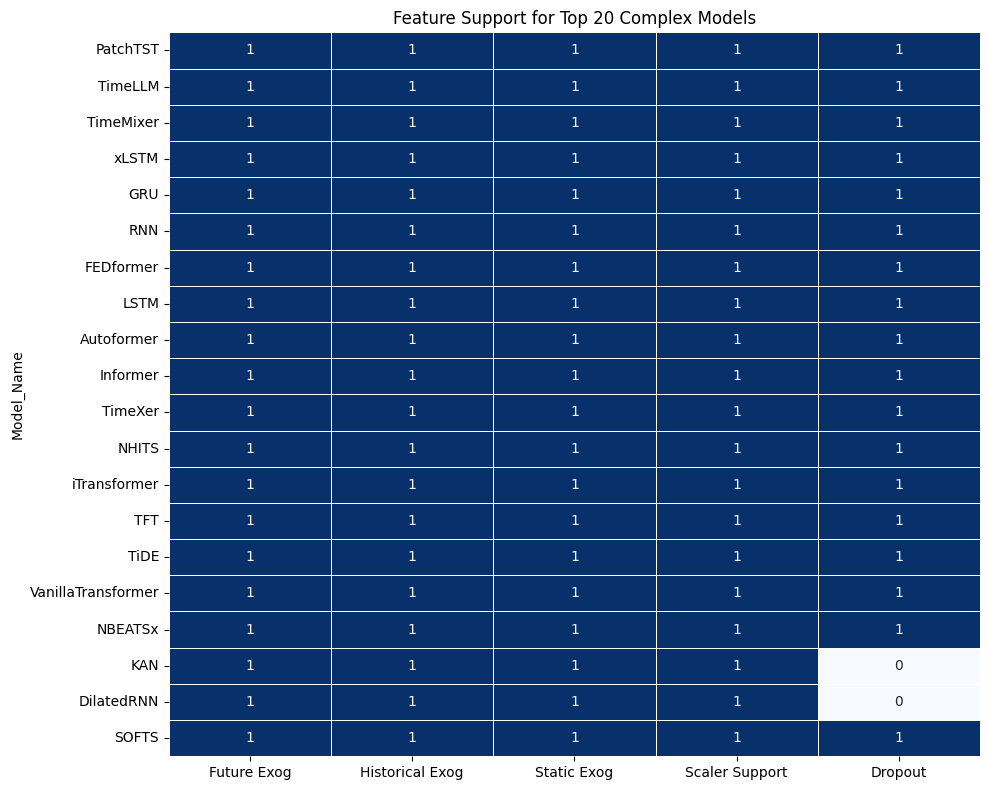

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSVデータの読み込み
df = pd.read_csv('neuralforecast_structure.csv')

def classify_model_architecture(name):
    """モデル名からアーキテクチャ系統を推測する"""
    name_lower = name.lower()
    # 系統ごとのキーワード定義
    if any(k in name_lower for k in ['transformer', 'former', 'tst', 'attention', 'llm']):
        return 'Transformer-based'
    elif any(k in name_lower for k in ['nbeats', 'nhits', 'mlp', 'linear', 'tide', 'tsmixer', 'kan']):
        return 'MLP/Linear-based'
    elif any(k in name_lower for k in ['rnn', 'lstm', 'gru', 'deepar', 'dilated']):
        return 'RNN-based'
    elif any(k in name_lower for k in ['cnn', 'tcn']):
        return 'CNN-based'
    else:
        return 'Other/Generic'

def extract_capabilities(args_str):
    """引数リストから主要な機能フラグを抽出する"""
    if pd.isna(args_str):
        return {}
    
    args = [x.strip() for x in args_str.split(',')]
    
    # 特定の引数名が含まれているかチェック
    caps = {
        'Future Exog': any('futr_exog' in a for a in args),    # 未来の外生変数
        'Historical Exog': any('hist_exog' in a for a in args),# 過去の外生変数
        'Static Exog': any('stat_exog' in a for a in args),    # 静的な外生変数
        'Validation Support': any('valid' in a for a in args), # バリデーションデータの明示的指定
        'Dropout': any('dropout' in a for a in args),          # ドロップアウト正則化
        'Scaler Support': any('scaler' in a for a in args),    # 内部スケーラー
    }
    return caps

# --- メイン処理 ---

# 1. Modelsカテゴリの抽出
models_df = df[df['Path'].str.contains('neuralforecast.models') & 
               (df['Type'].str.contains('type') | df['Type'].str.contains('class'))].copy()
models_df['Model_Name'] = models_df['Path'].apply(lambda x: x.split('.')[-1])

# 2. 分類と機能抽出の適用
models_df['Architecture'] = models_df['Model_Name'].apply(classify_model_architecture)
capabilities = models_df['Arguments'].apply(extract_capabilities).apply(pd.Series)
models_analysis = pd.concat([models_df, capabilities], axis=1)

# 3. 複雑さ（引数数）の計算
models_analysis['Num_Arguments'] = models_analysis['Arguments'].apply(
    lambda x: len(x.split(',')) if isinstance(x, str) else 0
)

# 4. 重複排除とソート
models_analysis_unique = models_analysis.drop_duplicates(subset='Model_Name').sort_values('Num_Arguments', ascending=False)

# 5. 可視化 (例: 機能サポート状況のヒートマップ)
plt.figure(figsize=(10, 8))
heatmap_data = models_analysis_unique.set_index('Model_Name')[
    ['Future Exog', 'Historical Exog', 'Static Exog', 'Scaler Support', 'Dropout']
].astype(int)

# Top 20のみ表示
sns.heatmap(heatmap_data.head(20), annot=True, cmap='Blues', cbar=False, linewidths=.5)
plt.title('Feature Support for Top 20 Complex Models')
plt.tight_layout()
plt.savefig('model_features_heatmap.png')
plt.show()

# データ保存
models_analysis_unique.to_csv('neuralforecast_models_detailed.csv', index=False)

In [6]:
import sqlite3
import pandas as pd

# PostgreSQLを使用する場合は以下のように接続を変更してください
# import psycopg2
# conn = psycopg2.connect("dbname=test user=postgres password=secret")

def setup_database_and_insert_data(csv_path, db_path='neuralforecast_meta.db'):
    # 1. データの読み込み
    df = pd.read_csv(csv_path)

    # 2. DB接続とテーブル作成 (SQLite用)
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # テーブル作成 (DDL)
    cursor.executescript("""
        CREATE TABLE IF NOT EXISTS catalog (
            object_id INTEGER PRIMARY KEY AUTOINCREMENT,
            full_path TEXT UNIQUE, object_name TEXT, object_type TEXT, 
            category TEXT, docstring TEXT, return_annotation TEXT
        );
        CREATE TABLE IF NOT EXISTS arguments (
            argument_id INTEGER PRIMARY KEY AUTOINCREMENT,
            object_id INTEGER, arg_name TEXT, arg_order INTEGER,
            FOREIGN KEY(object_id) REFERENCES catalog(object_id)
        );
        CREATE TABLE IF NOT EXISTS model_stats (
            stat_id INTEGER PRIMARY KEY AUTOINCREMENT,
            object_id INTEGER, architecture_type TEXT, num_args INTEGER, feature_score INTEGER,
            supports_future_exog BOOLEAN, supports_hist_exog BOOLEAN, supports_static_exog BOOLEAN,
            supports_scaler BOOLEAN, supports_dropout BOOLEAN,
            FOREIGN KEY(object_id) REFERENCES catalog(object_id)
        );
    """)

    # ヘルパー関数: カテゴリ抽出
    def get_category(path):
        parts = path.split('.')
        return parts[1] if len(parts) > 1 else 'root'

    # ヘルパー関数: アーキテクチャ分類
    def classify_arch(name):
        name = name.lower()
        if any(k in name for k in ['transformer', 'former', 'tst', 'attention', 'llm']): return 'Transformer-based'
        if any(k in name for k in ['nbeats', 'nhits', 'mlp', 'linear', 'tide']): return 'MLP/Linear-based'
        if any(k in name for k in ['rnn', 'lstm', 'gru', 'deepar']): return 'RNN-based'
        if any(k in name for k in ['cnn', 'tcn']): return 'CNN-based'
        return 'Other'

    print("Inserting data...")
    
    # 3. データ処理と挿入ループ
    for _, row in df.iterrows():
        # --- Catalog テーブル ---
        full_path = row['Path']
        obj_name = full_path.split('.')[-1]
        category = get_category(full_path)
        
        cursor.execute('''
            INSERT INTO catalog (full_path, object_name, object_type, category, docstring, return_annotation)
            VALUES (?, ?, ?, ?, ?, ?)
        ''', (full_path, obj_name, row['Type'], category, row['Summary (Docstring)'], row['Return_Annotation']))
        
        object_id = cursor.lastrowid
        
        # --- Arguments テーブル (文字列解析) ---
        args_str = str(row['Arguments'])
        arg_list = []
        if args_str and args_str not in ['nan', 'N/A']:
            arg_list = [x.strip() for x in args_str.split(',')]
            for idx, arg in enumerate(arg_list):
                if arg:
                    cursor.execute('INSERT INTO arguments (object_id, arg_name, arg_order) VALUES (?, ?, ?)',
                                   (object_id, arg, idx))
        
        # --- Model Stats テーブル (詳細分析) ---
        if category == 'models' and ('class' in str(row['Type']).lower() or 'type' in str(row['Type']).lower()):
            arch = classify_arch(obj_name)
            # 機能フラグの抽出
            caps = {
                'futr': any('futr_exog' in a for a in arg_list),
                'hist': any('hist_exog' in a for a in arg_list),
                'stat': any('stat_exog' in a for a in arg_list),
                'scaler': any('scaler' in a for a in arg_list),
                'drop': any('dropout' in a for a in arg_list)
            }
            score = sum(caps.values())
            
            cursor.execute('''
                INSERT INTO model_stats (
                    object_id, architecture_type, num_args, feature_score,
                    supports_future_exog, supports_hist_exog, supports_static_exog, supports_scaler, supports_dropout
                ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (object_id, arch, len(arg_list), score, caps['futr'], caps['hist'], caps['stat'], caps['scaler'], caps['drop']))

    conn.commit()
    conn.close()
    print("Database setup complete.")

# 実行
setup_database_and_insert_data('neuralforecast_structure.csv')

Inserting data...
Database setup complete.


In [9]:
import sqlite3
import pandas as pd
import numpy as np

def build_knowledge_graph_from_csv(csv_path='neuralforecast_structure.csv', db_path='neuralforecast_knowledge.db'):
    # 1. データの読み込み
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows from {csv_path}")
    except FileNotFoundError:
        print(f"Error: {csv_path} not found. Please ensure the file is in the current directory.")
        return

    # 2. データベース接続とスキーマ定義
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # --- テーブル定義 (DDL) ---
    # Objects Table: すべてのクラス・関数のカタログ
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS objects (
        object_id INTEGER PRIMARY KEY AUTOINCREMENT,
        full_path TEXT UNIQUE NOT NULL,
        name TEXT NOT NULL,
        type TEXT,
        module TEXT,
        docstring TEXT,
        return_annotation TEXT
    )
    ''')

    # Parameters Table: 引数の詳細定義
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS parameters (
        param_id INTEGER PRIMARY KEY AUTOINCREMENT,
        object_id INTEGER,
        name TEXT NOT NULL,
        position INTEGER,
        FOREIGN KEY(object_id) REFERENCES objects(object_id) ON DELETE CASCADE
    )
    ''')

    # Capabilities Table: モデルの機能マトリクス (モデルのみ)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS capabilities (
        cap_id INTEGER PRIMARY KEY AUTOINCREMENT,
        object_id INTEGER,
        architecture_family TEXT,
        num_parameters INTEGER,
        supports_future_exog BOOLEAN,
        supports_hist_exog BOOLEAN,
        supports_static_exog BOOLEAN,
        supports_scaler BOOLEAN,
        supports_dropout BOOLEAN,
        FOREIGN KEY(object_id) REFERENCES objects(object_id) ON DELETE CASCADE
    )
    ''')

    # 以前のデータをクリア（再実行用）
    cursor.execute("DELETE FROM capabilities")
    cursor.execute("DELETE FROM parameters")
    cursor.execute("DELETE FROM objects")
    conn.commit()

    # --- 解析ロジック ---
    def classify_architecture(name):
        name = name.lower()
        if any(k in name for k in ['transformer', 'former', 'tst', 'attention', 'llm']): return 'Transformer-based'
        if any(k in name for k in ['nbeats', 'nhits', 'mlp', 'linear', 'tide', 'kan', 'tsmixer']): return 'MLP/Linear-based'
        if any(k in name for k in ['rnn', 'lstm', 'gru', 'deepar']): return 'RNN-based'
        if any(k in name for k in ['cnn', 'tcn']): return 'CNN-based'
        return 'Other'

    def get_module_category(path):
        parts = path.split('.')
        # neuralforecast.models.NBEATS -> models
        if len(parts) > 1:
            return parts[1]
        return 'root'

    print("Processing and inserting data...")
    
    # 3. データ処理と挿入ループ
    for _, row in df.iterrows():
        full_path = row['Path']
        obj_name = full_path.split('.')[-1]
        obj_type = row['Type']
        module = get_module_category(full_path)
        
        # --- Objects Table への挿入 ---
        cursor.execute('''
            INSERT INTO objects (full_path, name, type, module, docstring, return_annotation)
            VALUES (?, ?, ?, ?, ?, ?)
        ''', (full_path, obj_name, obj_type, module, row['Summary (Docstring)'], row['Return_Annotation']))
        
        object_id = cursor.lastrowid
        
        # --- 引数の解析 (String -> List) ---
        args_raw = str(row['Arguments'])
        arg_list = []
        if args_raw and args_raw not in ['nan', 'N/A', '']:
            arg_list = [x.strip() for x in args_raw.split(',')]
            
            # --- Parameters Table への挿入 ---
            for i, arg in enumerate(arg_list):
                if arg:
                    cursor.execute('''
                        INSERT INTO parameters (object_id, name, position)
                        VALUES (?, ?, ?)
                    ''', (object_id, arg, i))

        # --- Capabilities Table (モデルの場合のみ詳細分析) ---
        # 条件: modelsモジュールに含まれ、かつクラスであること
        if module == 'models' and ('class' in str(obj_type).lower() or 'type' in str(obj_type).lower()):
            arch = classify_architecture(obj_name)
            
            # 機能フラグの抽出
            caps = {
                'futr': any('futr_exog' in a for a in arg_list),
                'hist': any('hist_exog' in a for a in arg_list),
                'stat': any('stat_exog' in a for a in arg_list),
                'scaler': any('scaler' in a for a in arg_list),
                'drop': any('dropout' in a for a in arg_list)
            }
            
            cursor.execute('''
                INSERT INTO capabilities (
                    object_id, architecture_family, num_parameters,
                    supports_future_exog, supports_hist_exog, supports_static_exog,
                    supports_scaler, supports_dropout
                ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (object_id, arch, len(arg_list), 
                  caps['futr'], caps['hist'], caps['stat'], caps['scaler'], caps['drop']))

    conn.commit()
    print("Database built successfully.")

    # 4. 検証クエリの実行
    print("\n--- [Verification] Top 5 Complex Transformer Models ---")
    query = '''
    SELECT o.name, c.architecture_family, c.num_parameters, c.supports_future_exog
    FROM objects o
    JOIN capabilities c ON o.object_id = c.object_id
    WHERE c.architecture_family = 'Transformer-based'
    ORDER BY c.num_parameters DESC
    LIMIT 5
    '''
    result = pd.read_sql_query(query, conn)
    print(result.to_markdown(index=False))
    
    conn.close()

if __name__ == "__main__":
    build_knowledge_graph_from_csv()

Loaded 411 rows from neuralforecast_structure.csv
Processing and inserting data...
Database built successfully.

--- [Verification] Top 5 Complex Transformer Models ---
| name      | architecture_family   |   num_parameters |   supports_future_exog |
|:----------|:----------------------|-----------------:|-----------------------:|
| PatchTST  | Transformer-based     |               47 |                      1 |
| PatchTST  | Transformer-based     |               47 |                      1 |
| TimeLLM   | Transformer-based     |               46 |                      1 |
| TimeLLM   | Transformer-based     |               46 |                      1 |
| FEDformer | Transformer-based     |               41 |                      1 |


In [11]:
import sqlite3
import pandas as pd

def get_model_info_from_db(model_name, db_path='neuralforecast_knowledge.db'):
    """
    指定されたモデル名の情報をDBから抽出して表示する
    """
    conn = sqlite3.connect(db_path)
    
    # 1. 基本情報と機能（Capabilities）の取得
    # LEFT JOINしているのは、capabilitiesがモデル以外（関数など）には存在しないため
    query_basic = """
    SELECT 
        o.object_id, 
        o.name, 
        o.full_path, 
        o.docstring,
        c.architecture_family,
        c.supports_future_exog,
        c.supports_hist_exog,
        c.supports_static_exog
    FROM objects o
    LEFT JOIN capabilities c ON o.object_id = c.object_id
    WHERE o.name = ? AND o.module = 'models'
    """
    
    # モデル名で検索
    df_basic = pd.read_sql_query(query_basic, conn, params=(model_name,))
    
    if df_basic.empty:
        print(f"Error: Model '{model_name}' not found in the database.")
        conn.close()
        return

    # IDの取得
    obj_id = df_basic.iloc[0]['object_id']
    
    # 2. パラメータ（引数）情報の取得
    query_params = """
    SELECT name as param_name, position
    FROM parameters
    WHERE object_id = ?
    ORDER BY position
    """
    df_params = pd.read_sql_query(query_params, conn, params=(obj_id,))
    
    conn.close()

    # --- 結果の表示 ---
    info = df_basic.iloc[0]
    
    print(f"=== Model Analysis: {info['name']} ===")
    print(f"Path: {info['full_path']}")
    print(f"Architecture: {info['architecture_family']}")
    print(f"\n[Summary]\n{info['docstring']}")
    
    print(f"\n[Key Capabilities]")
    print(f"- Future Exogenous Variables: {'✅ Yes' if info['supports_future_exog'] else '❌ No'}")
    print(f"- Historical Exogenous Variables: {'✅ Yes' if info['supports_hist_exog'] else '❌ No'}")
    print(f"- Static Exogenous Variables: {'✅ Yes' if info['supports_static_exog'] else '❌ No'}")
    
    print(f"\n[Parameters ({len(df_params)})]")
    # パラメータを見やすく整形して表示
    print(df_params['param_name'].to_list())

# --- 実行例 ---
# AutoRNNが存在しないため、サンプルとして 'RNN' を指定
target_model = 'RNN' 
get_model_info_from_db(target_model)

# 試しに 'Autoformer' なども確認可能
# get_model_info_from_db('Autoformer')

=== Model Analysis: RNN ===
Path: neuralforecast.models.RNN
Architecture: RNN-based

[Summary]
RNN

[Key Capabilities]
- Future Exogenous Variables: ✅ Yes
- Historical Exogenous Variables: ✅ Yes
- Static Exogenous Variables: ✅ Yes

[Parameters (0)]
[]


In [12]:
import pandas as pd
import inspect
from neuralforecast.auto import AutoRNN
from neuralforecast.core import BaseAuto

def inspect_auto_model(model_class):
    """AutoModel（AutoRNN等）の詳細情報を解析して表示する"""
    
    # 1. クラスの基本情報
    print(f"=== Model: {model_class.__name__} ===")
    print(f"Parent Class: {model_class.__bases__[0].__name__}")
    print(f"Module: {model_class.__module__}\n")

    # 2. 初期化引数 (__init__) の解析
    # AutoRNN自体か、継承元のBaseAutoの初期化引数を取得
    sig = inspect.signature(model_class.__init__)
    init_params = []
    for name, param in sig.parameters.items():
        if name == 'self': continue
        init_params.append({
            "Category": "Init Parameter",
            "Name": name,
            "Default": str(param.default) if param.default != inspect.Parameter.empty else "Required",
            "Annotation": str(param.annotation).replace("typing.", "")
        })

    # 3. デフォルトの探索空間 (default_config) の解析
    # AutoモデルはここでRNNのハイパーパラメータ範囲を定義しています
    if hasattr(model_class, 'default_config'):
        for key, value in model_class.default_config.items():
            init_params.append({
                "Category": "Search Space (Default Config)",
                "Name": key,
                "Default": str(value),
                "Annotation": "Hyperparameter Range"
            })

    # 4. 主要メソッド (fit, predict) の解析
    for method_name in ['fit', 'predict']:
        method = getattr(model_class, method_name, None)
        if method:
            sig = inspect.signature(method)
            # 返り値の型ヒントを取得
            ret_anno = str(sig.return_annotation).replace("typing.", "")
            init_params.append({
                "Category": f"Method: {method_name}",
                "Name": "Return Value",
                "Default": "N/A",
                "Annotation": ret_anno
            })

    # DataFrame化して表示
    df_info = pd.DataFrame(init_params)
    
    # 表示調整
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    
    print(df_info.to_markdown(index=False))
    return df_info

# --- 実行 ---
df_autornn = inspect_auto_model(AutoRNN)

=== Model: AutoRNN ===
Parent Class: BaseAuto
Module: neuralforecast.auto

| Category                      | Name                            | Default                                                                            | Annotation               |
|:------------------------------|:--------------------------------|:-----------------------------------------------------------------------------------|:-------------------------|
| Init Parameter                | h                               | Required                                                                           | <class 'inspect._empty'> |
| Init Parameter                | loss                            | MAE()                                                                              | <class 'inspect._empty'> |
| Init Parameter                | valid_loss                      | None                                                                               | <class 'inspect._empty'> |
| Init Parameter         

In [13]:
import neuralforecast
import pkgutil
import importlib
import inspect
import pandas as pd
import sqlite3
import os
import sys

def analyze_neuralforecast_comprehensive(db_path='neuralforecast_comprehensive.db'):
    """
    neuralforecastライブラリを網羅的に解析し、結果をSQLiteデータベースに保存する。
    """
    print(f"Scanning neuralforecast version: {neuralforecast.__version__}")
    
    # --- 1. DB初期化 ---
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # テーブル定義
    cursor.executescript("""
    DROP TABLE IF EXISTS items;
    DROP TABLE IF EXISTS parameters;
    DROP TABLE IF EXISTS search_space;

    -- クラス・関数・モジュールの基本情報
    CREATE TABLE items (
        item_id INTEGER PRIMARY KEY AUTOINCREMENT,
        full_path TEXT UNIQUE,
        name TEXT,
        type TEXT,       -- 'class', 'function', 'module'
        parent_module TEXT,
        docstring TEXT,  -- 概要
        source_file TEXT
    );

    -- 引数・パラメータの詳細情報
    CREATE TABLE parameters (
        param_id INTEGER PRIMARY KEY AUTOINCREMENT,
        item_id INTEGER,
        name TEXT,
        default_value TEXT,
        annotation TEXT,
        kind TEXT,       -- 'POSITIONAL_OR_KEYWORD' etc.
        FOREIGN KEY(item_id) REFERENCES items(item_id)
    );

    -- AutoModelの探索空間 (Default Config)
    CREATE TABLE search_space (
        config_id INTEGER PRIMARY KEY AUTOINCREMENT,
        item_id INTEGER,
        param_name TEXT,
        search_value TEXT, -- 探索範囲の定義文字列
        FOREIGN KEY(item_id) REFERENCES items(item_id)
    );
    """)
    conn.commit()

    # --- 2. 再帰的パッケージ探索 (pkgutil) ---
    # neuralforecastパッケージのパスを取得
    package_path = os.path.dirname(neuralforecast.__file__)
    
    # 発見したモジュールをインポート
    found_modules = []
    # walk_packagesはサブモジュールも再帰的に探す
    for _, name, ispkg in pkgutil.walk_packages([package_path], prefix="neuralforecast."):
        try:
            module = importlib.import_module(name)
            found_modules.append(module)
        except ImportError as e:
            # 依存関係不足などでインポートできない場合はスキップ
            print(f"Skipping {name}: {e}")
        except Exception as e:
            print(f"Error importing {name}: {e}")

    print(f"Found {len(found_modules)} submodules.")

    # --- 3. オブジェクト解析 ---
    seen_items = set() # 重複防止用

    for module in found_modules:
        module_name = module.__name__
        
        # モジュール内のメンバーを走査
        for name, obj in inspect.getmembers(module):
            # プライベートメンバーと他ライブラリからのインポートを除外
            if name.startswith('_'): continue
            
            # 定義元が neuralforecast でないものは除外 (numpy, torchなどを拾わないように)
            obj_module = getattr(obj, '__module__', '')
            if not obj_module or not obj_module.startswith('neuralforecast'):
                continue
            
            full_path = f"{obj_module}.{name}"
            
            if full_path in seen_items:
                continue
            seen_items.add(full_path)

            # タイプ判定
            item_type = 'unknown'
            if inspect.isclass(obj): item_type = 'class'
            elif inspect.isfunction(obj): item_type = 'function'
            else: continue # 変数などはスキップ

            # ドキュメント取得
            doc = inspect.getdoc(obj)
            doc_summary = doc.split('\n')[0] if doc else None
            source_file = inspect.getsourcefile(obj)

            # DBへ登録 (Items)
            cursor.execute("""
                INSERT INTO items (full_path, name, type, parent_module, docstring, source_file)
                VALUES (?, ?, ?, ?, ?, ?)
            """, (full_path, name, item_type, module_name, doc_summary, source_file))
            
            item_id = cursor.lastrowid

            # --- 引数解析 (Parameters) ---
            target_obj = obj
            if item_type == 'class':
                # クラスなら __init__ を見る
                target_obj = getattr(obj, '__init__', None)

            if target_obj and (inspect.isfunction(target_obj) or inspect.ismethod(target_obj)):
                try:
                    sig = inspect.signature(target_obj)
                    for param_name, param in sig.parameters.items():
                        if param_name == 'self': continue
                        
                        def_val = str(param.default) if param.default != inspect.Parameter.empty else "REQUIRED"
                        annot = str(param.annotation) if param.annotation != inspect.Parameter.empty else ""
                        
                        cursor.execute("""
                            INSERT INTO parameters (item_id, name, default_value, annotation, kind)
                            VALUES (?, ?, ?, ?, ?)
                        """, (item_id, param_name, def_val, annot, str(param.kind)))
                except (ValueError, TypeError):
                    pass # シグネチャが取得できない場合

            # --- AutoModelの探索空間解析 (Search Space) ---
            # 'Auto'で始まるクラス、かつ default_config 属性を持つ場合
            if item_type == 'class' and name.startswith('Auto') and hasattr(obj, 'default_config'):
                try:
                    config = getattr(obj, 'default_config', {})
                    if isinstance(config, dict):
                        for conf_key, conf_val in config.items():
                            cursor.execute("""
                                INSERT INTO search_space (item_id, param_name, search_value)
                                VALUES (?, ?, ?)
                            """, (item_id, conf_key, str(conf_val)))
                except Exception:
                    pass

    conn.commit()
    conn.close()
    print(f"Analysis complete. Data saved to {db_path}")

# --- 4. 結果確認用ヘルパー ---
def show_sample_results(db_path='neuralforecast_comprehensive.db'):
    conn = sqlite3.connect(db_path)
    
    print("\n=== Summary Stats ===")
    df_summary = pd.read_sql("SELECT type, COUNT(*) as count FROM items GROUP BY type", conn)
    print(df_summary.to_markdown(index=False))
    
    print("\n=== Top 5 Models by Parameter Count ===")
    query = """
    SELECT i.name, COUNT(p.param_id) as param_count 
    FROM items i 
    JOIN parameters p ON i.item_id = p.item_id 
    WHERE i.type='class' AND i.parent_module LIKE '%models%'
    GROUP BY i.name 
    ORDER BY param_count DESC LIMIT 5
    """
    print(pd.read_sql(query, conn).to_markdown(index=False))

    print("\n=== AutoRNN Default Search Space (Example) ===")
    query_auto = """
    SELECT i.name, s.param_name, s.search_value 
    FROM items i 
    JOIN search_space s ON i.item_id = s.item_id 
    WHERE i.name = 'AutoRNN'
    """
    print(pd.read_sql(query_auto, conn).to_markdown(index=False))
    
    conn.close()

if __name__ == "__main__":
    analyze_neuralforecast_comprehensive()
    show_sample_results()

Scanning neuralforecast version: 3.1.2
Found 51 submodules.
Analysis complete. Data saved to neuralforecast_comprehensive.db

=== Summary Stats ===
| type     |   count |
|:---------|--------:|
| class    |     227 |
| function |      78 |

=== Top 5 Models by Parameter Count ===
| name              |   param_count |
|:------------------|--------------:|
| PatchTST_backbone |            34 |
| TSTiEncoder       |            22 |
| EncoderLayer      |            18 |
| NBEATSBlock       |            16 |
| DecoderLayer      |            16 |

=== AutoRNN Default Search Space (Example) ===
| name    | param_name                      | search_value                                                      |
|:--------|:--------------------------------|:------------------------------------------------------------------|
| AutoRNN | input_size_multiplier           | [-1, 4, 16, 64]                                                   |
| AutoRNN | inference_input_size_multiplier | [-1]             

In [15]:
import neuralforecast
import pkgutil
import importlib
import inspect
import sqlite3
import pandas as pd
import os
import ray.tune.search.sample as ray_sample

# --- 1. Helper Functions (Deep Analysis) ---

def decode_ray_object(obj):
    """Ray Tuneオブジェクトを可読な文字列に変換"""
    if isinstance(obj, ray_sample.Categorical):
        return str(obj.categories)
    elif isinstance(obj, ray_sample.Integer):
        return f"Integer({obj.lower} ~ {obj.upper})"
    elif isinstance(obj, ray_sample.Float):
        dist_type = "LogUniform" if hasattr(obj, 'sampler') and 'Log' in str(obj.sampler) else "Uniform"
        return f"Float({obj.lower} ~ {obj.upper}, {dist_type})"
    elif callable(obj):
        return "Function"
    return str(obj)

def get_params_dict(func_or_class):
    """関数またはクラスの引数とデフォルト値を辞書として取得"""
    params = {}
    try:
        if inspect.isclass(func_or_class):
            target = func_or_class.__init__
        else:
            target = func_or_class
        
        sig = inspect.signature(target)
        for name, param in sig.parameters.items():
            if name == 'self': continue
            default = param.default if param.default != inspect.Parameter.empty else "REQUIRED"
            params[name] = default
    except (ValueError, TypeError):
        pass
    return params

def find_base_model_class(auto_model_name, all_classes_registry):
    """Autoモデル名からベースモデルクラスを検索 (例: AutoRNN -> RNN)"""
    base_name = auto_model_name.replace("Auto", "")
    # 完全一致で探す
    for name, cls_obj in all_classes_registry.items():
        if name == base_name:
            return cls_obj
    return None

# --- 2. Main Logic (Traversal & DB Build) ---

def build_neuralforecast_knowledge_base(db_path='neuralforecast_knowledge_base.db'):
    print(f"Scanning NeuralForecast v{neuralforecast.__version__}...")
    
    # DB初期化
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.executescript("""
    DROP TABLE IF EXISTS items;
    DROP TABLE IF EXISTS parameters;
    DROP TABLE IF EXISTS auto_config;

    -- クラス・関数・モジュールのカタログ
    CREATE TABLE items (
        item_id INTEGER PRIMARY KEY AUTOINCREMENT,
        full_path TEXT UNIQUE,
        name TEXT,
        type TEXT,
        docstring TEXT
    );

    -- 通常の引数情報 (Signature)
    CREATE TABLE parameters (
        param_id INTEGER PRIMARY KEY AUTOINCREMENT,
        item_id INTEGER,
        name TEXT,
        default_value TEXT,
        annotation TEXT,
        FOREIGN KEY(item_id) REFERENCES items(item_id)
    );

    -- Autoモデルの詳細設定 (探索空間 vs ベースモデルデフォルト)
    CREATE TABLE auto_config (
        config_id INTEGER PRIMARY KEY AUTOINCREMENT,
        item_id INTEGER,
        param_name TEXT,
        search_space_decoded TEXT, -- Autoモデルでの探索範囲
        base_model_default TEXT,   -- ベースモデルでのデフォルト値
        FOREIGN KEY(item_id) REFERENCES items(item_id)
    );
    """)
    
    # 1. パッケージの全探索とクラスレジストリの作成
    package_path = os.path.dirname(neuralforecast.__file__)
    all_modules = []
    class_registry = {} # {ClassName: ClassObject} ベースモデル検索用
    
    # 再帰的にモジュールをロード
    for _, name, _ in pkgutil.walk_packages([package_path], prefix="neuralforecast."):
        try:
            module = importlib.import_module(name)
            all_modules.append(module)
            # クラスをレジストリに登録
            for member_name, member_obj in inspect.getmembers(module, inspect.isclass):
                if member_obj.__module__.startswith("neuralforecast"):
                    class_registry[member_name] = member_obj
        except Exception:
            continue

    print(f"Loaded {len(all_modules)} modules and {len(class_registry)} classes.")

    # 2. 詳細解析とDB登録
    seen_paths = set()
    
    for module in all_modules:
        for name, obj in inspect.getmembers(module):
            # フィルタリング
            if name.startswith('_'): continue
            obj_mod = getattr(obj, '__module__', '')
            if not obj_mod.startswith('neuralforecast'): continue
            
            full_path = f"{obj_mod}.{name}"
            if full_path in seen_paths: continue
            seen_paths.add(full_path)
            
            # タイプ判定
            obj_type = 'unknown'
            if inspect.isclass(obj): obj_type = 'class'
            elif inspect.isfunction(obj): obj_type = 'function'
            else: continue

            # ドキュメント
            doc = inspect.getdoc(obj)
            doc_short = doc.split('\n')[0] if doc else None

            # Itemsテーブルへ登録
            cursor.execute("INSERT INTO items (full_path, name, type, docstring) VALUES (?, ?, ?, ?)",
                           (full_path, name, obj_type, doc_short))
            item_id = cursor.lastrowid
            
            # --- パラメータ解析 (Signature) ---
            # クラスなら__init__、関数ならそのまま
            target = obj.__init__ if obj_type == 'class' else obj
            try:
                sig = inspect.signature(target)
                for pname, param in sig.parameters.items():
                    if pname == 'self': continue
                    def_val = str(param.default) if param.default != inspect.Parameter.empty else "REQUIRED"
                    annot = str(param.annotation) if param.annotation != inspect.Parameter.empty else ""
                    
                    cursor.execute("""
                        INSERT INTO parameters (item_id, name, default_value, annotation)
                        VALUES (?, ?, ?, ?)
                    """, (item_id, pname, def_val, annot))
            except (ValueError, TypeError):
                pass

            # --- Autoモデル詳細解析 (Search Space & Base Comparison) ---
            if obj_type == 'class' and name.startswith('Auto') and hasattr(obj, 'default_config'):
                # ベースモデルを探す
                base_cls = find_base_model_class(name, class_registry)
                base_defaults = get_params_dict(base_cls) if base_cls else {}
                
                # default_config (探索空間) を解析
                config = getattr(obj, 'default_config', {})
                if isinstance(config, dict):
                    for conf_key, conf_val in config.items():
                        decoded_val = decode_ray_object(conf_val)
                        base_def = str(base_defaults.get(conf_key, "Not in Base Init"))
                        
                        cursor.execute("""
                            INSERT INTO auto_config (item_id, param_name, search_space_decoded, base_model_default)
                            VALUES (?, ?, ?, ?)
                        """, (item_id, conf_key, decoded_val, base_def))
                        
    conn.commit()
    conn.close()
    print(f"Database successfully built at: {db_path}")

# --- 3. Verification Helper ---
def verify_db_content(db_path='neuralforecast_knowledge_base.db'):
    conn = sqlite3.connect(db_path)
    
    print("\n=== Sample 1: AutoRNN Search Space vs Base Default ===")
    query = """
    SELECT i.name as Model, a.param_name, a.base_model_default, a.search_space_decoded
    FROM auto_config a
    JOIN items i ON a.item_id = i.item_id
    WHERE i.name = 'AutoRNN'
    """
    print(pd.read_sql(query, conn).to_markdown(index=False))
    
    print("\n=== Sample 2: Complex Model Parameters (PatchTST) ===")
    query2 = """
    SELECT i.name, p.name as Arg, p.default_value
    FROM parameters p
    JOIN items i ON p.item_id = i.item_id
    WHERE i.name = 'PatchTST'
    LIMIT 10
    """
    print(pd.read_sql(query2, conn).to_markdown(index=False))
    conn.close()

if __name__ == "__main__":
    build_neuralforecast_knowledge_base()
    verify_db_content()

Scanning NeuralForecast v3.1.2...
Loaded 51 modules and 209 classes.
Database successfully built at: neuralforecast_knowledge_base.db

=== Sample 1: AutoRNN Search Space vs Base Default ===
| Model   | param_name                      | base_model_default   | search_space_decoded            |
|:--------|:--------------------------------|:---------------------|:--------------------------------|
| AutoRNN | input_size_multiplier           | Not in Base Init     | [-1, 4, 16, 64]                 |
| AutoRNN | inference_input_size_multiplier | Not in Base Init     | [-1]                            |
| AutoRNN | h                               | REQUIRED             | None                            |
| AutoRNN | encoder_hidden_size             | 128                  | [16, 32, 64, 128]               |
| AutoRNN | encoder_n_layers                | 2                    | Integer(1 ~ 4)                  |
| AutoRNN | context_size                    | None                 | [5, 10, 50]         

In [17]:
import inspect
import pandas as pd
import warnings
from neuralforecast.auto import AutoRNN
from neuralforecast.models import RNN
try:
    import ray.tune.search.sample as ray_sample
    RAY_AVAILABLE = True
except ImportError:
    RAY_AVAILABLE = False
    warnings.warn("ray module not found. Search space objects will not be fully decoded.")

def decode_ray_object(obj):
    """Ray Tuneの探索空間オブジェクトを可読な文字列に変換"""
    if not RAY_AVAILABLE: return str(obj)
    if isinstance(obj, ray_sample.Categorical):
        return f"Choice({obj.categories})"
    elif isinstance(obj, ray_sample.Integer):
        return f"Integer({obj.lower} ~ {obj.upper})"
    elif isinstance(obj, ray_sample.Float):
        dist = "LogUniform" if hasattr(obj, 'sampler') and 'Log' in str(obj.sampler) else "Uniform"
        return f"Float({obj.lower} ~ {obj.upper}, {dist})"
    elif callable(obj):
        return "Function"
    return str(obj)

def get_init_params(cls_obj):
    """クラス初期化引数の詳細を取得"""
    sig = inspect.signature(cls_obj.__init__)
    data = []
    for name, param in sig.parameters.items():
        if name == 'self': continue
        default = "REQUIRED" if param.default == inspect.Parameter.empty else str(param.default)
        annotation = str(param.annotation).replace("typing.", "").replace("<class '", "").replace("'>", "")
        data.append({"Arg": name, "Default": default, "Type": annotation})
    return pd.DataFrame(data)

# --- 1. BaseAuto (AutoRNNの親クラス) の引数 ---
print("=== 1. AutoRNN (BaseAuto) Configuration Arguments ===")
print("これらは AutoRNN の初期化時に直接指定する引数です（学習制御用）。")
df_auto = get_init_params(AutoRNN)
print(df_auto.to_markdown(index=False))

# --- 2. AutoRNN Default Config (探索空間) ---
print("\n=== 2. AutoRNN Default Search Space (Hyperparameters) ===")
print("これらは config 引数で上書き可能な、モデルの探索パラメータです。")
config = getattr(AutoRNN, 'default_config', {})
config_data = [{"Parameter": k, "Default/Range": decode_ray_object(v)} for k, v in config.items()]
print(pd.DataFrame(config_data).to_markdown(index=False))

# --- 3. Base Model (RNN) Arguments (外生変数など) ---
print("\n=== 3. RNN Model Arguments (For 'config') ===")
print("これらは config 辞書に含めることでモデルに渡せる引数です（外生変数はここ）。")
df_base = get_init_params(RNN)
# 外生変数に関連する引数のみ抽出
exog_vars = ['futr_exog_list', 'hist_exog_list', 'stat_exog_list']
df_exog = df_base[df_base['Arg'].isin(exog_vars) | df_base['Arg'].str.contains('size') | df_base['Arg'].str.contains('h')]
print(df_exog.to_markdown(index=False))

# --- 4. 具体的な設定例 (Usage) ---
print("\n=== 4. Example: How to configure Exogenous Variables ===")
print("""
# 外生変数の設定例
config = {
    # 外生変数リスト (データセットのカラム名)
    'futr_exog_list': ['holiday', 'weather_forecast'], # 未来も既知の変数
    'hist_exog_list': ['sales_lag1'],                  # 過去のみ既知の変数
    'stat_exog_list': ['store_id', 'city'],            # 静的変数（ID等）
    
    # 固定したいハイパーパラメータ (探索させない場合)
    'max_steps': 500,
    'encoder_hidden_size': 64
}

# Autoモデルの初期化
model = AutoRNN(
    h=12,               # 予測ホライズン
    loss=MAE(),         # 損失関数
    config=config,      # 上記の設定を渡す
    num_samples=20      # 探索試行回数
)
""")

=== 1. AutoRNN (BaseAuto) Configuration Arguments ===
これらは AutoRNN の初期化時に直接指定する引数です（学習制御用）。
| Arg            | Default                                                                            | Type           |
|:---------------|:-----------------------------------------------------------------------------------|:---------------|
| h              | REQUIRED                                                                           | inspect._empty |
| loss           | MAE()                                                                              | inspect._empty |
| valid_loss     | None                                                                               | inspect._empty |
| config         | None                                                                               | inspect._empty |
| search_alg     | <ray.tune.search.basic_variant.BasicVariantGenerator object at 0x0000029555AC96D0> | inspect._empty |
| num_samples    | 10                                        

In [16]:
import sqlite3
import pandas as pd
import os

def generate_final_reports(db_path='neuralforecast_knowledge_base.db'):
    if not os.path.exists(db_path):
        print(f"Error: Database {db_path} not found.")
        return

    conn = sqlite3.connect(db_path)
    
    # --- レポート1: モデル/クラスの全カタログ (引数リスト付き) ---
    print("Generating Model Catalog...")
    query_catalog = """
    SELECT 
        i.full_path,
        i.name AS Object_Name,
        i.type AS Type,
        i.docstring AS Summary,
        GROUP_CONCAT(p.name, ', ') AS Arguments_List,
        COUNT(p.param_id) AS Num_Arguments
    FROM items i
    LEFT JOIN parameters p ON i.item_id = p.item_id
    WHERE i.type IN ('class', 'function')
    GROUP BY i.item_id
    ORDER BY i.full_path
    """
    df_catalog = pd.read_sql_query(query_catalog, conn)
    
    # 見やすさのためにNaNを空文字に
    df_catalog.fillna('', inplace=True)
    
    # CSV出力
    catalog_file = 'neuralforecast_model_catalog.csv'
    df_catalog.to_csv(catalog_file, index=False, encoding='utf-8-sig')
    print(f"Saved: {catalog_file} ({len(df_catalog)} rows)")

    # --- レポート2: AutoML探索空間の詳細対比 ---
    print("Generating AutoML Config Report...")
    query_automl = """
    SELECT 
        i.name AS Auto_Model,
        a.param_name AS Parameter,
        a.base_model_default AS Base_Default,
        a.search_space_decoded AS Auto_Search_Space
    FROM auto_config a
    JOIN items i ON a.item_id = i.item_id
    ORDER BY i.name, a.param_name
    """
    df_automl = pd.read_sql_query(query_automl, conn)
    
    # CSV出力
    automl_file = 'neuralforecast_automl_config.csv'
    df_automl.to_csv(automl_file, index=False, encoding='utf-8-sig')
    print(f"Saved: {automl_file} ({len(df_automl)} rows)")
    
    conn.close()
    
    # --- サンプル表示 ---
    print("\n=== [Catalog Sample] Top 3 Complex Models ===")
    print(df_catalog.sort_values('Num_Arguments', ascending=False).head(3)[['Object_Name', 'Num_Arguments']].to_markdown(index=False))

    print("\n=== [AutoML Sample] AutoRNN Config ===")
    print(df_automl[df_automl['Auto_Model'] == 'AutoRNN'].head().to_markdown(index=False))

if __name__ == "__main__":
    generate_final_reports()

Generating Model Catalog...
Saved: neuralforecast_model_catalog.csv (305 rows)
Generating AutoML Config Report...
Saved: neuralforecast_automl_config.csv (377 rows)

=== [Catalog Sample] Top 3 Complex Models ===
| Object_Name   |   Num_Arguments |
|:--------------|----------------:|
| PatchTST      |              47 |
| TimeLLM       |              46 |
| TimeMixer     |              43 |

=== [AutoML Sample] AutoRNN Config ===
| Auto_Model   | Parameter           | Base_Default   | Auto_Search_Space   |
|:-------------|:--------------------|:---------------|:--------------------|
| AutoRNN      | batch_size          | 32             | [16, 32]            |
| AutoRNN      | context_size        | None           | [5, 10, 50]         |
| AutoRNN      | decoder_hidden_size | 128            | [16, 32, 64, 128]   |
| AutoRNN      | encoder_hidden_size | 128            | [16, 32, 64, 128]   |
| AutoRNN      | encoder_n_layers    | 2              | Integer(1 ~ 4)      |


## neuralforecast

### model

In [21]:
import pandas as pd
import inspect
import neuralforecast
from neuralforecast.core import BaseAuto
# Autoモデルを認識させるため、neuralforecast.autoモジュールをインポート
import neuralforecast.auto

def get_baseauto_models():
    """
    BaseAutoクラスを継承しているすべてのモデルを再帰的に探索し、
    その情報をDataFrameとして返す関数。
    """
    # 重複防止用のセット
    found_classes = set()
    # 探索キュー（初期値はBaseAuto自身）
    queue = [BaseAuto]
    
    data_list = []

    while queue:
        current_cls = queue.pop(0)
        
        # 直下のサブクラスを取得してループ
        for subclass in current_cls.__subclasses__():
            if subclass not in found_classes:
                found_classes.add(subclass)
                queue.append(subclass)  # 孫クラスがあれば探索するためにキューに追加
                
                # --- 情報の抽出 ---
                model_name = subclass.__name__
                module_path = subclass.__module__
                full_path = f"{module_path}.{model_name}"
                
                # ドキュメント（1行目の要約）を取得
                doc = inspect.getdoc(subclass)
                summary = doc.split('\n')[0] if doc else "No description available"
                
                data_list.append({
                    "Model_Name": model_name,    # モデル名 (例: AutoRNN)
                    "Full_Path": full_path,      # インポートパス
                    "Summary": summary           # 機能概要
                })
    
    # DataFrameの作成
    df = pd.DataFrame(data_list)
    
    # 名前順にソートして整理
    if not df.empty:
        df = df.sort_values(by="Model_Name").reset_index(drop=True)
        
    return df

# --- 実行 ---
if __name__ == "__main__":
    df_models = get_baseauto_models()
    
    print(f"Total Auto Models Found: {len(df_models)}")
    print("-" * 60)
    # テーブルの内容を表示（Markdown形式で見やすく）
    print(df_models.to_markdown(index=False))
    
    # 次のステップ用にCSV保存する場合
    # df_models.to_csv("baseauto_models_list.csv", index=False)

Total Auto Models Found: 34
------------------------------------------------------------
| Model_Name             | Full_Path                                  | Summary                                                                       |
|:-----------------------|:-------------------------------------------|:------------------------------------------------------------------------------|
| AutoAutoformer         | neuralforecast.auto.AutoAutoformer         | Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to |
| AutoBiTCN              | neuralforecast.auto.AutoBiTCN              | Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to |
| AutoDLinear            | neuralforecast.auto.AutoDLinear            | Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to |
| AutoDeepAR             | neuralforecast.auto.AutoDeepAR             | Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to |

In [22]:
len(df_models)

34

### horison

In [30]:
import pandas as pd
import torch
import inspect
import neuralforecast.models
import neuralforecast.auto
from neuralforecast.core import BaseAuto
import logging
import numpy as np

# ログ設定（エラー詳細を見たい場合は DEBUG）
logging.basicConfig(level=logging.ERROR)

def find_min_h_recursive():
    """
    全Autoモデルに対応するベースモデルを特定し、
    h を段階的に増やしながら正常に動作する最小値を特定する。
    戻り値の 'Min_h' 列は整数型 (Int64) とする。
    """
    
    # 探索対象のAutoモデル収集
    auto_models = []
    for name, obj in inspect.getmembers(neuralforecast.auto):
        if inspect.isclass(obj) and issubclass(obj, BaseAuto) and name.startswith("Auto"):
            auto_models.append(name)
    
    results = []
    h_candidates = [1, 2, 4, 6, 8, 12, 16, 24, 32, 48, 60, 96]

    print(f"Scanning {len(auto_models)} models for numeric Minimum 'h'...")

    for auto_name in sorted(auto_models):
        base_name = auto_name.replace("Auto", "")
        
        # ベースモデルクラス取得
        model_cls = None
        for module_name, module_obj in inspect.getmembers(neuralforecast.models):
            if hasattr(module_obj, base_name):
                model_cls = getattr(module_obj, base_name)
                break
        
        if model_cls is None:
            results.append({
                "Auto_Model": auto_name,
                "Base_Model": "Not Found",
                "Min_h": -1,  # 数値型: 見つからない場合は -1
                "Status": "Skipped",
                "Note": "Base model not found"
            })
            continue

        # --- 最小 h 探索 ---
        found_min_h = False
        min_h_val = 999 # 初期値: 探索範囲外を表す大きな値
        last_error = ""

        for h_test in h_candidates:
            try:
                # 初期化引数
                init_args = {'h': h_test, 'input_size': 96} 
                
                sig = inspect.signature(model_cls.__init__)
                for param_name, param in sig.parameters.items():
                    if param.default == inspect.Parameter.empty and param_name not in ['self', 'h', 'input_size']:
                        if 'list' in param_name: init_args[param_name] = []
                        elif 'size' in param_name: init_args[param_name] = 16
                        elif 'n_series' in param_name: init_args[param_name] = 1
                        elif 'stat_exog' in param_name: init_args[param_name] = None
                        else: init_args[param_name] = 1

                model = model_cls(**init_args)
                
                if hasattr(model, 'patch_len') and model.patch_len > h_test:
                     raise ValueError(f"h({h_test}) < patch_len({model.patch_len})")

                found_min_h = True
                min_h_val = h_test
                break

            except Exception as e:
                last_error = str(e)
                continue
        
        status = "OK" if found_min_h else "Failed"
        note = f"Verified at h={min_h_val}" if found_min_h else f"Error: {last_error[:30]}..."
        
        if "patch_len" in last_error: note += " (h >= patch_len)"
        elif "seasonality" in last_error: note += " (Seasonality)"

        results.append({
            "Auto_Model": auto_name,
            "Base_Model": base_name,
            "Min_h": min_h_val, # ここには必ず整数が入る
            "Status": status,
            "Note": note
        })

    # DataFrame作成
    df_results = pd.DataFrame(results)
    
    # 型変換を明示的に行う (Min_h を int型に)
    # 失敗(-1や999)もそのまま整数として扱う
    df_results['Min_h'] = df_results['Min_h'].astype(int)

    return df_results

# --- 実行 ---
if __name__ == "__main__":
    df_min_h_numeric = find_min_h_recursive()
    
    # 結果表示
    print("\n=== Minimum 'h' Settings (Numeric) ===")
    print(df_min_h_numeric.to_markdown(index=False))
    
    # 必要ならCSV保存
    df_min_h_numeric.to_csv("neuralforecast_min_h_numeric.csv", index=False)

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


Scanning 34 models for numeric Minimum 'h'...


Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1



=== Minimum 'h' Settings (Numeric) ===
| Auto_Model             | Base_Model         |   Min_h | Status   | Note                                     |
|:-----------------------|:-------------------|--------:|:---------|:-----------------------------------------|
| AutoAutoformer         | Not Found          |      -1 | Skipped  | Base model not found                     |
| AutoBiTCN              | BiTCN              |       1 | OK       | Verified at h=1                          |
| AutoDLinear            | DLinear            |       1 | OK       | Verified at h=1                          |
| AutoDeepAR             | DeepAR             |       1 | OK       | Verified at h=1                          |
| AutoDeepNPTS           | DeepNPTS           |       1 | OK       | Verified at h=1                          |
| AutoDilatedRNN         | DilatedRNN         |       1 | OK       | Verified at h=1                          |
| AutoFEDformer          | FEDformer          |       1 | OK    

### arguments

In [31]:
import pandas as pd
import inspect
import neuralforecast.auto
import neuralforecast.models
from neuralforecast.core import BaseAuto

def get_all_model_arguments():
    """
    全Autoモデルを対象に、以下の2種類の引数を取得してテーブル化する。
    1. Autoモデル自体のInit引数（h, loss, num_samples等）
    2. ベースモデルのInit引数（config辞書で指定可能な encoder_hidden_size 等）
    """
    
    # 1. 探索対象のAutoモデルを収集
    auto_models = []
    for name, obj in inspect.getmembers(neuralforecast.auto):
        if inspect.isclass(obj) and issubclass(obj, BaseAuto) and name.startswith("Auto"):
            auto_models.append((name, obj))
    
    data_list = []
    
    print(f"Analyzing arguments for {len(auto_models)} Auto Models...")

    for auto_name, auto_cls in sorted(auto_models):
        base_name = auto_name.replace("Auto", "")
        
        # --- A. Autoモデル自体の引数 (Control Params) ---
        try:
            sig_auto = inspect.signature(auto_cls.__init__)
            for param_name, param in sig_auto.parameters.items():
                if param_name == 'self': continue
                
                # デフォルト値と型ヒントの整形
                default_val = "REQUIRED" if param.default == inspect.Parameter.empty else str(param.default)
                annotation = str(param.annotation).replace("typing.", "").replace("<class '", "").replace("'>", "")
                
                data_list.append({
                    "Auto_Model": auto_name,
                    "Base_Model": base_name,
                    "Category": "Control Param (Auto Init)",
                    "Argument": param_name,
                    "Default_Value": default_val,
                    "Type_Hint": annotation,
                    "Description": "Set in AutoModel(...)"
                })
        except Exception as e:
            print(f"Error analyzing Auto Init for {auto_name}: {e}")

        # --- B. ベースモデルの引数 (Hyperparameters / Config) ---
        # ベースモデルクラスの特定
        model_cls = None
        for module_name, module_obj in inspect.getmembers(neuralforecast.models):
            if hasattr(module_obj, base_name):
                model_cls = getattr(module_obj, base_name)
                break
        
        if model_cls:
            try:
                sig_base = inspect.signature(model_cls.__init__)
                for param_name, param in sig_base.parameters.items():
                    if param_name == 'self': continue
                    
                    # h や loss など AutoInit と重複するものは除外するか、区別する
                    # ここでは全てリストアップし、Categoryで区別
                    
                    default_val = "REQUIRED" if param.default == inspect.Parameter.empty else str(param.default)
                    annotation = str(param.annotation).replace("typing.", "").replace("<class '", "").replace("'>", "")
                    
                    data_list.append({
                        "Auto_Model": auto_name,
                        "Base_Model": base_name,
                        "Category": "Model Param (via config)",
                        "Argument": param_name,
                        "Default_Value": default_val,
                        "Type_Hint": annotation,
                        "Description": "Set in config={...}"
                    })
            except Exception as e:
                print(f"Error analyzing Base Init for {base_name}: {e}")
        else:
            # ベースモデルが見つからない場合
            data_list.append({
                "Auto_Model": auto_name,
                "Base_Model": "Not Found",
                "Category": "Error",
                "Argument": "N/A",
                "Default_Value": "N/A",
                "Type_Hint": "N/A",
                "Description": "Base model class not found"
            })

    # DataFrame作成
    df = pd.DataFrame(data_list)
    return df

# --- 実行と保存 ---
if __name__ == "__main__":
    df_args = get_all_model_arguments()
    
    # 結果の表示（例として AutoRNN の一部を表示）
    print("\n=== Argument Catalog Sample (AutoRNN) ===")
    sample = df_args[df_args['Auto_Model'] == 'AutoRNN'].head(15)
    print(sample[['Category', 'Argument', 'Default_Value', 'Type_Hint']].to_markdown(index=False))
    
    # 全データをCSV保存
    csv_filename = "neuralforecast_all_model_arguments.csv"
    df_args.to_csv(csv_filename, index=False)
    print(f"\nFull catalog saved to {csv_filename} ({len(df_args)} rows)")

Analyzing arguments for 34 Auto Models...

=== Argument Catalog Sample (AutoRNN) ===
| Category                  | Argument       | Default_Value                                                                      | Type_Hint      |
|:--------------------------|:---------------|:-----------------------------------------------------------------------------------|:---------------|
| Control Param (Auto Init) | h              | REQUIRED                                                                           | inspect._empty |
| Control Param (Auto Init) | loss           | MAE()                                                                              | inspect._empty |
| Control Param (Auto Init) | valid_loss     | None                                                                               | inspect._empty |
| Control Param (Auto Init) | config         | None                                                                               | inspect._empty |
| Control Param (Auto

In [32]:
df_args

,Auto_Model,Base_Model,Category,Argument,Default_Value,Type_Hint,Description
0,AutoAutoformer,former,Control Param (Auto Init),h,REQUIRED,inspect._empty,Set in AutoModel(...)
1,AutoAutoformer,former,Control Param (Auto Init),loss,MAE(),inspect._empty,Set in AutoModel(...)
2,AutoAutoformer,former,Control Param (Auto Init),valid_loss,None,inspect._empty,Set in AutoModel(...)
3,AutoAutoformer,former,Control Param (Auto Init),config,None,inspect._empty,Set in AutoModel(...)
4,AutoAutoformer,former,Control Param (Auto Init),search_alg,<ray.tune.search.basic_variant.BasicVariantGenerator object at 0x000002955613DF10>,inspect._empty,Set in AutoModel(...)
5,AutoAutoformer,former,Control Param (Auto Init),num_samples,10,inspect._empty,Set in AutoModel(...)
6,AutoAutoformer,former,Control Param (Auto Init),refit_with_val,False,inspect._empty,Set in AutoModel(...)
7,AutoAutoformer,former,Control Param (Auto Init),cpus,12,inspect._empty,Set in AutoModel(...)
8,AutoAutoformer,former,Control Param (Auto Init),gpus,0,inspect._empty,Set in AutoModel(...)
9,AutoAutoformer,former,Control Param (Auto Init),verbose,False,inspect._empty,Set in AutoModel(...)


### loss

In [39]:
import pandas as pd
import numpy as np
import inspect
import torch
import neuralforecast.auto
import neuralforecast.losses.pytorch
from neuralforecast.core import BaseAuto
import logging
import json

# ログ抑制
logging.basicConfig(level=logging.CRITICAL)

# --- 1. 解析用ヘルパー関数 ---

def analyze_signature(cls_obj, exclude_list=[]):
    """
    クラスの__init__を解析し、必須引数(Required)とデフォルト引数を分類する。
    """
    try:
        sig = inspect.signature(cls_obj.__init__)
    except ValueError:
        return {}, {}

    required = {}
    defaults = {}

    for name, param in sig.parameters.items():
        if name in ['self', 'args', 'kwargs'] + exclude_list:
            continue
        
        type_hint = str(param.annotation).replace("typing.", "").replace("<class '", "").replace("'>", "")
        if type_hint == "inspect._empty": type_hint = "Any"

        if param.default == inspect.Parameter.empty:
            required[name] = type_hint
        else:
            defaults[name] = str(param.default)
            
    return required, defaults

def get_dummy_value(param_name):
    if param_name == 'n_series': return 2
    if param_name == 'S': return np.eye(2).astype(np.float32)
    if param_name == 'input_size': return 24
    if param_name == 'patch_len': return 8
    if param_name == 'step_size': return 1
    if param_name == 'cls_model': return None
    if param_name == 'valid_loss': return neuralforecast.losses.pytorch.MAE()
    return 1

# --- 2. メイン生成ロジック ---

def build_refined_configuration_table():
    # A. モデル一覧
    auto_models = []
    for name, obj in inspect.getmembers(neuralforecast.auto):
        if inspect.isclass(obj) and issubclass(obj, BaseAuto) and name.startswith("Auto"):
            auto_models.append((name, obj))

    # B. 損失関数一覧
    losses = []
    for name, obj in inspect.getmembers(neuralforecast.losses.pytorch):
        if inspect.isclass(obj) and issubclass(obj, torch.nn.Module) and name != 'BasePointLoss':
            if obj.__module__.startswith("neuralforecast"):
                losses.append((name, obj))

    results = []
    print(f"Designing Refined Table for {len(auto_models)} Models x {len(losses)} Losses...")

    for model_name, model_cls in sorted(auto_models):
        
        base_auto_args = ['h', 'loss', 'valid_loss', 'config', 'search_alg', 'num_samples', 'cpus', 'gpus', 'verbose', 'alias', 'backend', 'callbacks', 'refit_with_val']
        model_reqs, _ = analyze_signature(model_cls, exclude_list=base_auto_args)

        for loss_name, loss_cls in losses:
            
            loss_reqs, _ = analyze_signature(loss_cls)
            
            # --- インスタンス化準備 ---
            loss_kwargs = {}
            for req_arg in loss_reqs:
                if req_arg == 'quantiles': loss_kwargs[req_arg] = [0.5]
                elif req_arg == 'level': loss_kwargs[req_arg] = [90]
                elif req_arg == 'distribution': loss_kwargs[req_arg] = 'Normal'
                elif req_arg == 'num_output': loss_kwargs[req_arg] = 1
                elif req_arg == 'q': loss_kwargs[req_arg] = 0.5
                else: loss_kwargs[req_arg] = 1
            
            try:
                loss_instance = loss_cls(**loss_kwargs)
            except:
                continue 

            # Direct Args
            direct_kwargs = {}
            for req_arg in model_reqs:
                direct_kwargs[req_arg] = get_dummy_value(req_arg)
            
            if 'valid_loss' in str(inspect.signature(model_cls.__init__)):
                 if 'valid_loss' not in direct_kwargs:
                     direct_kwargs['valid_loss'] = neuralforecast.losses.pytorch.MAE()

            # Config Args
            config_dummy = {}
            if "Patch" in model_name or "TimeXer" in model_name:
                config_dummy['patch_len'] = 8

            # --- 検証 ---
            status_int = 1 # Ready
            error_msg = ""
            is_default_int = 1 if loss_name == "MAE" else 0

            try:
                model = model_cls(
                    h=12,
                    loss=loss_instance,
                    config=config_dummy,
                    num_samples=1,
                    cpus=1,
                    verbose=False,
                    **direct_kwargs
                )
            except Exception as e:
                status_int = 0 # Error
                error_msg = str(e)
                if "incompatible" in error_msg.lower(): error_msg = "Incompatible Output Shape"
            
            # --- データ格納 (カラム展開) ---
            # 必須引数を辞書文字列ではなく、具体的なキーの存在として表現
            # 例: direct_arg_n_series = 1 (True)
            
            entry = {
                "cls_model": model_name,
                "loss": loss_name,
                "is_default": is_default_int,
                "status": status_int,
                "error_detail": error_msg if status_int == 0 else ""
            }
            
            # 1. Direct Args (モデル初期化引数) の展開
            # よくある必須引数をカラム化
            known_direct_args = ['n_series', 'S', 'input_size']
            for arg in known_direct_args:
                entry[f"req_arg_{arg}"] = 1 if arg in model_reqs else 0
            
            # その他の引数はまとめて文字列で
            other_direct = {k:v for k,v in model_reqs.items() if k not in known_direct_args}
            entry["other_req_args"] = str(other_direct) if other_direct else ""

            # 2. Loss Args (損失関数引数) の展開
            known_loss_args = ['level', 'quantiles', 'distribution', 'q']
            for arg in known_loss_args:
                entry[f"loss_arg_{arg}"] = 1 if arg in loss_reqs else 0
            
            # 3. Config Args (推奨Config) の展開
            # 値が入っている場合のみ記録
            if config_dummy:
                for k, v in config_dummy.items():
                    entry[f"config_{k}"] = v
            else:
                entry["config_patch_len"] = "" # カラム確保用

            results.append(entry)

    df = pd.DataFrame(results)
    # NaNを適切な空値に
    df.fillna("", inplace=True)
    return df

# --- 実行 ---
if __name__ == "__main__":
    df_refined = build_refined_configuration_table()
    
    # カラム並び替え
    base_cols = ["cls_model", "loss", "is_default", "status"]
    arg_cols = [c for c in df_refined.columns if c not in base_cols and c != "error_detail"]
    final_cols = base_cols + arg_cols + ["error_detail"]
    
    df_final = df_refined[final_cols]

    # サンプル表示
    print("\n=== Refined Blueprint Table (Sample) ===")
    mask = df_final['cls_model'].isin(['AutoRNN', 'AutoTSMixer']) & df_final['loss'].isin(['MAE', 'MQLoss'])
    print(df_final[mask].to_markdown(index=False))
    
    # 保存
    filename = "neuralforecast_refined_blueprint.csv"
    df_final.to_csv(filename, index=False)
    print(f"\nSaved to {filename}")

Designing Refined Table for 34 Models x 22 Losses...

=== Refined Blueprint Table (Sample) ===
| cls_model   | loss   |   is_default |   status |   req_arg_n_series |   req_arg_S |   req_arg_input_size | other_req_args   |   loss_arg_level |   loss_arg_quantiles |   loss_arg_distribution |   loss_arg_q | config_patch_len   | config_n_series   | error_detail   |
|:------------|:-------|-------------:|---------:|-------------------:|------------:|---------------------:|:-----------------|-----------------:|---------------------:|------------------------:|-------------:|:-------------------|:------------------|:---------------|
| AutoRNN     | MAE    |            1 |        1 |                  0 |           0 |                    0 |                  |                0 |                    0 |                       0 |            0 |                    |                   |                |
| AutoRNN     | MQLoss |            0 |        1 |                  0 |           0 |             

C:\Windows\Temp\ipykernel_10576\3433417735.py:168: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("", inplace=True)


### config

In [43]:
import pandas as pd
import inspect
import neuralforecast.auto
import neuralforecast.models
from neuralforecast.core import BaseAuto
import logging
# Ray Tuneのオブジェクトを解析するために必要
try:
    from ray.tune.search import sample as ray_sample
    RAY_AVAILABLE = True
except ImportError:
    RAY_AVAILABLE = False

# ログ設定
logging.basicConfig(level=logging.CRITICAL)

def decode_ray_object(obj):
    """Ray Tuneの探索空間オブジェクトを可読な文字列に変換"""
    if not RAY_AVAILABLE:
        return str(obj)
    
    if isinstance(obj, ray_sample.Categorical):
        return f"Choice: {obj.categories}"
    elif isinstance(obj, ray_sample.Integer):
        return f"IntRange: {obj.lower} to {obj.upper}"
    elif isinstance(obj, ray_sample.Float):
        dist_type = "LogUniform" if hasattr(obj, 'sampler') and 'Log' in str(obj.sampler) else "Uniform"
        return f"FloatRange: {obj.lower} to {obj.upper} ({dist_type})"
    elif isinstance(obj, ray_sample.Function):
        return "Function (Custom Sampler)"
    elif isinstance(obj, list):
        return f"List: {obj}"
    else:
        # その他の型やプリミティブ値
        return str(obj)

def classify_parameter_type(name):
    """引数名からパラメータのカテゴリを推論"""
    name_lower = name.lower()
    if any(x in name_lower for x in ['hidden', 'layer', 'dropout', 'embedding', 'head', 'kernel', 'filter', 'activation']):
        return "Architecture (Model Structure)"
    elif any(x in name_lower for x in ['lr', 'learning_rate', 'decay', 'optim', 'batch', 'step', 'epoch', 'iter']):
        return "Optimization (Training)"
    elif any(x in name_lower for x in ['exog', 'input', 'series', 'context', 'h_']):
        return "Data / Features"
    elif any(x in name_lower for x in ['loss', 'metric', 'valid']):
        return "Loss / Evaluation"
    else:
        return "Other / Miscellaneous"

def get_config_arguments_catalog_detailed():
    """
    全Autoモデルについて、config引数を探索し、
    Ray Tuneの探索空間オブジェクトをデコードして詳細テーブル化する。
    """
    
    auto_models = []
    for name, obj in inspect.getmembers(neuralforecast.auto):
        if inspect.isclass(obj) and issubclass(obj, BaseAuto) and name.startswith("Auto"):
            auto_models.append((name, obj))
            
    catalog_data = []
    print(f"Scanning & Decoding Configs for {len(auto_models)} Models...")

    for auto_name, auto_cls in sorted(auto_models):
        base_name = auto_name.replace("Auto", "")
        
        base_cls = None
        for module_name, module_obj in inspect.getmembers(neuralforecast.models):
            if hasattr(module_obj, base_name):
                base_cls = getattr(module_obj, base_name)
                break
        
        if base_cls is None: continue

        # Autoモデルのデフォルト探索空間
        default_search_space = getattr(auto_cls, 'default_config', {})
        
        try:
            sig = inspect.signature(base_cls.__init__)
            exclude_args = ['self', 'h', 'loss', 'valid_loss', 'alias'] 
            
            for param_name, param in sig.parameters.items():
                if param_name in exclude_args or param_name.startswith('_'):
                    continue
                
                # --- 情報抽出 ---
                if param.default == inspect.Parameter.empty:
                    default_val = "REQUIRED"
                    is_required = 1
                else:
                    default_val = str(param.default)
                    is_required = 0
                
                type_hint = str(param.annotation).replace("typing.", "").replace("<class '", "").replace("'>", "")
                if type_hint == "inspect._empty": type_hint = "Any"
                
                # --- Ray Object Decoding ---
                in_auto_search = 1 if param_name in default_search_space else 0
                search_space_decoded = ""
                
                if in_auto_search:
                    raw_val = default_search_space[param_name]
                    search_space_decoded = decode_ray_object(raw_val)
                
                category = classify_parameter_type(param_name)

                catalog_data.append({
                    "Auto_Model": auto_name,
                    "Base_Model": base_name,
                    "Config_Argument": param_name,
                    "Category": category,
                    "Is_Required": is_required,
                    "Default_Value": default_val,
                    "Type_Hint": type_hint,
                    "In_Default_Search": in_auto_search,
                    "Search_Space_Example": search_space_decoded
                })

        except Exception as e:
            pass

    # DataFrame化
    df = pd.DataFrame(catalog_data)
    cols = [
        "Auto_Model", "Config_Argument", "Is_Required", "Default_Value", 
        "Category", "Type_Hint", "In_Default_Search", "Search_Space_Example"
    ]
    return df[cols]

# --- 実行 ---
if __name__ == "__main__":
    df_config_detailed = get_config_arguments_catalog_detailed()
    
    # CSV保存
    filename = "neuralforecast_config_arguments_decoded.csv"
    df_config_detailed.to_csv(filename, index=False)
    
    # サンプル表示 (AutoRNN)
    print("\n=== Config Arguments Table (Decoded Sample: AutoRNN) ===")
    mask = (df_config_detailed['Auto_Model'] == 'AutoRNN') & (df_config_detailed['In_Default_Search'] == 1)
    print(df_config_detailed[mask].head(10).to_markdown(index=False))
    
    print(f"\nSaved decoded catalog to {filename}")

Scanning & Decoding Configs for 34 Models...

=== Config Arguments Table (Decoded Sample: AutoRNN) ===
| Auto_Model   | Config_Argument     |   Is_Required | Default_Value   | Category                       | Type_Hint     |   In_Default_Search | Search_Space_Example                   |
|:-------------|:--------------------|--------------:|:----------------|:-------------------------------|:--------------|--------------------:|:---------------------------------------|
| AutoRNN      | encoder_n_layers    |             0 | 2               | Architecture (Model Structure) | int           |                   1 | IntRange: 1 to 4                       |
| AutoRNN      | encoder_hidden_size |             0 | 128             | Architecture (Model Structure) | int           |                   1 | Choice: [16, 32, 64, 128]              |
| AutoRNN      | context_size        |             0 | None            | Data / Features                | Optional[int] |                   1 | Choice: [5, 1

### search_alg

In [18]:
import inspect
import pandas as pd
import optuna.samplers
import ray.tune.search

def get_available_search_algs():
    # --- 1. Optuna Samplers ---
    optuna_algs = []
    # BaseSamplerを継承する全クラスを取得
    for name, obj in inspect.getmembers(optuna.samplers):
        if inspect.isclass(obj) and issubclass(obj, optuna.samplers.BaseSampler):
            if name != "BaseSampler":
                optuna_algs.append(name)

    # --- 2. Ray Tune Searchers ---
    ray_algs = []
    from ray.tune.search import Searcher
    
    # 手動追加 (継承関係にないが重要なもの)
    ray_algs.append("BasicVariantGenerator")

    # Searcherを継承する全クラスを取得
    for name, obj in inspect.getmembers(ray.tune.search):
        if inspect.isclass(obj) and issubclass(obj, Searcher):
            if name != "Searcher":
                ray_algs.append(name)

    # --- 3. ソートと長さ調整 (修正箇所) ---
    # まずソートする
    optuna_sorted = sorted(list(set(optuna_algs))) # 重複排除も念のため
    ray_sorted = sorted(list(set(ray_algs)))

    # 最大長を取得
    max_len = max(len(optuna_sorted), len(ray_sorted))

    # 長さを揃えるために空文字(またはNone)を追加
    optuna_sorted += ["-"] * (max_len - len(optuna_sorted))
    ray_sorted += ["-"] * (max_len - len(ray_sorted))

    # DataFrame作成 (長さが保証されているためエラーにならない)
    df = pd.DataFrame({
        "Optuna_Samplers": optuna_sorted,
        "Ray_Searchers": ray_sorted
    })
    
    return df

# 実行
if __name__ == "__main__":
    try:
        df_algs = get_available_search_algs()
        print(f"=== Available Search Algorithms ({len(df_algs)} rows) ===")
        # 見やすく左寄せで表示
        pd.set_option('display.max_rows', None)
        print(df_algs.to_string(index=False))
    except Exception as e:
        print(f"Error: {e}")

=== Available Search Algorithms (11 rows) ===
    Optuna_Samplers         Ray_Searchers
      BaseGASampler BasicVariantGenerator
  BruteForceSampler    ConcurrencyLimiter
       CmaEsSampler              Repeater
          GPSampler                     -
        GridSampler                     -
     NSGAIIISampler                     -
      NSGAIISampler                     -
PartialFixedSampler                     -
         QMCSampler                     -
      RandomSampler                     -
         TPESampler                     -


In [26]:
import inspect
import pandas as pd
import textwrap
import typing

# Libraries
import optuna.samplers
import ray.tune.search
from ray.tune.search.basic_variant import BasicVariantGenerator

# Ray Modules
ray_searcher_modules = [
    'ray.tune.search.optuna.OptunaSearch',
    'ray.tune.search.hyperopt.HyperOptSearch',
    'ray.tune.search.bayesopt.BayesOptSearch',
    'ray.tune.search.bohb.TuneBOHB',
    'ray.tune.search.dragonfly.DragonflySearch',
    'ray.tune.search.skopt.SkOptSearch',
    'ray.tune.search.ax.AxSearch',
    'ray.tune.search.hebo.HEBO',
]

class RelationalExtractor:
    def __init__(self):
        # 3つのテーブル用リスト
        self.data_libs = []
        self.data_algos = []
        self.data_args = []
        
        # ID管理用カウンタ
        self.lib_counter = 1
        self.algo_counter = 1
        self.arg_counter = 1
        
        # 重複防止用キャッシュ {name: id}
        self.lib_map = {} 
        self.algo_map = {} # {(lib_id, algo_name): algo_id}

    def _get_lib_id(self, lib_name):
        """ライブラリIDを取得または作成"""
        if lib_name not in self.lib_map:
            lid = self.lib_counter
            self.data_libs.append({
                "library_id": lid,
                "library_name": lib_name
            })
            self.lib_map[lib_name] = lid
            self.lib_counter += 1
        return self.lib_map[lib_name]

    def _format_doc(self, cls_obj, full=False):
        doc = inspect.getdoc(cls_obj)
        if not doc: return ""
        if full: return doc # そのまま返す
        # Short version: 最初の空行までを取得
        lines = [line.strip() for line in doc.split('\n') if line.strip()]
        return lines[0] if lines else ""

    def _format_type(self, annotation):
        if annotation == inspect.Parameter.empty: return None
        s = str(annotation)
        # クリーニング
        for rm in ["typing.", "ray.tune.search.", "optuna.samplers._base.", "NoneType", "<class '", "'>"]:
            s = s.replace(rm, "")
        s = s.replace("ForwardRef", "")
        return s

    def _format_default(self, default):
        if default == inspect.Parameter.empty: return None
        if isinstance(default, str): return f"'{default}'"
        if hasattr(default, '__name__'): return f"<func: {default.__name__}>"
        return str(default)

    def register_algorithm(self, lib_name, algo_name, cls_obj):
        """アルゴリズムと引数を登録"""
        lib_id = self._get_lib_id(lib_name)
        
        # アルゴリズムの登録 (重複チェック)
        if (lib_id, algo_name) in self.algo_map:
            return
            
        algo_id = self.algo_counter
        self.data_algos.append({
            "algo_id": algo_id,
            "library_id": lib_id,
            "algo_name": algo_name,
            "description_short": self._format_doc(cls_obj, full=False),
            # "description_full": self._format_doc(cls_obj, full=True) # 必要ならコメントアウト解除
        })
        self.algo_map[(lib_id, algo_name)] = algo_id
        self.algo_counter += 1
        
        # 引数の登録
        try:
            sig = inspect.signature(cls_obj)
            for param_name, param in sig.parameters.items():
                if param_name == 'self': continue
                
                self.data_args.append({
                    "arg_id": self.arg_counter,
                    "algo_id": algo_id,
                    "arg_name": param_name,
                    "is_required": param.default == inspect.Parameter.empty,
                    "default_value": self._format_default(param.default),
                    "type_hint": self._format_type(param.annotation)
                })
                self.arg_counter += 1
                
            # 引数がない場合(BasicVariantGeneratorなど)もAlgorithmテーブルには残る
                
        except ValueError:
            pass # C拡張などで署名が取れない場合

    def extract_all(self):
        # 1. Optuna
        for name, obj in inspect.getmembers(optuna.samplers):
            if inspect.isclass(obj) and issubclass(obj, optuna.samplers.BaseSampler):
                if name != "BaseSampler":
                    self.register_algorithm("Optuna", name, obj)

        # 2. Ray (Searcher)
        for name, obj in inspect.getmembers(ray.tune.search):
            from ray.tune.search import Searcher
            if inspect.isclass(obj) and issubclass(obj, Searcher):
                if name != "Searcher":
                    self.register_algorithm("Ray", name, obj)
                    
        # 3. Ray (Specific)
        self.register_algorithm("Ray", "BasicVariantGenerator", BasicVariantGenerator)
        
        for module_path in ray_searcher_modules:
            try:
                mod_name, cls_name = module_path.rsplit('.', 1)
                mod = __import__(mod_name, fromlist=[cls_name])
                cls_obj = getattr(mod, cls_name)
                self.register_algorithm("Ray", cls_name, cls_obj)
            except:
                continue

        # DataFrame化
        df_libs = pd.DataFrame(self.data_libs)
        df_algos = pd.DataFrame(self.data_algos)
        df_args = pd.DataFrame(self.data_args)
        
        return df_libs, df_algos, df_args

# --- 実行 ---
if __name__ == "__main__":
    extractor = RelationalExtractor()
    df_libs, df_algos, df_args = extractor.extract_all()
    
    # 表示設定
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    print("\n=== 1. Libraries Table ===")
    display(df_libs)
    
    print("\n=== 2. Algorithms Table (Top 5) ===")
    display(df_algos.head(5))
    
    print("\n=== 3. Arguments Table (Top 10) ===")
    display(df_args.head(10))
    
    # --- 結合テスト (Validation Join) ---
    print("\n=== Validation: Joining Tables to recreate detailed view ===")
    # Arg -> Algo -> Lib の順で結合
    df_merged = df_args.merge(df_algos, on="algo_id").merge(df_libs, on="library_id")
    
    # 確認用カラム抽出
    view_cols = ["library_name", "algo_name", "arg_name", "is_required", "type_hint"]
    display(df_merged[view_cols].sort_values(["library_name", "algo_name", "is_required"], ascending=[True, True, False]).head(10))


=== 1. Libraries Table ===


,library_id,library_name
0,1,Optuna
1,2,Ray



=== 2. Algorithms Table (Top 5) ===


,algo_id,library_id,algo_name,description_short
0,1,1,BaseGASampler,Base class for Genetic Algorithm (GA) samplers.
1,2,1,BruteForceSampler,Sampler using brute force.
2,3,1,CmaEsSampler,A sampler using `cmaes <https://github.com/CyberAgentAILab/cmaes>`__ as the backend.
3,4,1,GPSampler,Sampler using Gaussian process-based Bayesian optimization.
4,5,1,GridSampler,Sampler using grid search.



=== 3. Arguments Table (Top 10) ===


,arg_id,algo_id,arg_name,is_required,default_value,type_hint
0,1,1,population_size,True,None,int | None
1,2,2,seed,False,None,int | None
2,3,2,avoid_premature_stop,False,False,bool
3,4,3,x0,False,None,"dict[str, Any] | None"
4,5,3,sigma0,False,None,float | None
5,6,3,n_startup_trials,False,1,int
6,7,3,independent_sampler,False,None,BaseSampler | None
7,8,3,warn_independent_sampling,False,True,bool
8,9,3,seed,False,None,int | None
9,10,3,consider_pruned_trials,False,False,bool



=== Validation: Joining Tables to recreate detailed view ===


,library_name,algo_name,arg_name,is_required,type_hint
0,Optuna,BaseGASampler,population_size,True,int | None
1,Optuna,BruteForceSampler,seed,False,int | None
2,Optuna,BruteForceSampler,avoid_premature_stop,False,bool
3,Optuna,CmaEsSampler,x0,False,"dict[str, Any] | None"
4,Optuna,CmaEsSampler,sigma0,False,float | None
5,Optuna,CmaEsSampler,n_startup_trials,False,int
6,Optuna,CmaEsSampler,independent_sampler,False,BaseSampler | None
7,Optuna,CmaEsSampler,warn_independent_sampling,False,bool
8,Optuna,CmaEsSampler,seed,False,int | None
9,Optuna,CmaEsSampler,consider_pruned_trials,False,bool


In [33]:
import inspect
import pandas as pd
import numpy as np
import warnings
import sys
import logging
import traceback

# --- 1. Library Imports & Fallbacks ---
try:
    from neuralforecast import auto as auto_modules
    from neuralforecast.auto import BaseAuto
    from neuralforecast.losses.pytorch import MAE
    from neuralforecast.models import NHITS
except ImportError:
    try:
        from neuralforecast.common import base_auto as auto_modules
        from neuralforecast.common.base_auto import BaseAuto
        from neuralforecast.losses.pytorch import MAE
        from neuralforecast.models import NHITS
    except ImportError:
        print("Critical Error: NeuralForecast components missing.")
        sys.exit(1)

import optuna
from ray import tune
from ray.tune.search.basic_variant import BasicVariantGenerator
from ray.tune.search.optuna import OptunaSearch

# --- 2. Constraint Solver (制約解決ロジック) ---
class ModelConstraintSolver:
    """
    モデルごとの初期化引数(init_kwargs)と
    探索空間設定(config)の制約を解決するクラス
    """
    def __init__(self):
        self.dummy_loss = MAE()
        # ダミーの階層行列 (2 bottom series -> 1 total)
        self.dummy_S = np.array([[1.0, 1.0], [1.0, 0.0], [0.0, 1.0]])

    def get_constraints(self, model_cls):
        """
        モデルクラスを受け取り、以下の2つを返す:
        1. init_kwargs: __init__に渡すべき必須引数
        2. config_updates: search_configに含めるべき必須キー
        """
        sig = inspect.signature(model_cls.__init__)
        params = sig.parameters.keys()
        
        init_kwargs = {}
        config_updates = {}
        
        # --- 共通制約: Loss関数 ---
        init_kwargs['loss'] = self.dummy_loss
        init_kwargs['valid_loss'] = self.dummy_loss
        
        # --- 制約A: 多変量モデル (n_series) ---
        if 'n_series' in params:
            init_kwargs['n_series'] = 2
            # OptunaバックエンドなどではConfig内にも要求される場合があるため念のため追加
            config_updates['n_series'] = 2
            
        # --- 制約B: 階層モデル (AutoHINT) ---
        if 'S' in params:
            init_kwargs['S'] = self.dummy_S
            # AutoHINTはConfig内に'reconciliation'キーが必須
            config_updates['reconciliation'] = 'MinTraceOLS'
            
        if 'cls_model' in params:
            init_kwargs['cls_model'] = NHITS

        return init_kwargs, config_updates

# --- 3. Validation Engine (検証エンジン) ---
class CompatibilityValidator:
    def __init__(self):
        self.solver = ModelConstraintSolver()
        self.results = []
        
    def _get_models(self):
        models = []
        for name, obj in inspect.getmembers(auto_modules):
            if inspect.isclass(obj) and issubclass(obj, BaseAuto) and obj is not BaseAuto:
                models.append(obj)
        return models

    def _get_strategies(self):
        strategies = []
        
        # Ray: Basic (Grid/Random)
        strategies.append({
            'backend': 'ray', 'alg_name': 'BasicVariant', 
            'instance': BasicVariantGenerator(random_state=1)
        })
        
        # Ray: Optuna (Wrapper)
        try:
            strategies.append({
                'backend': 'ray', 'alg_name': 'RayOptuna', 
                'instance': OptunaSearch(metric="loss", mode="min")
            })
        except: pass

        # Ray: HyperOpt
        try:
            from ray.tune.search.hyperopt import HyperOptSearch
            strategies.append({
                'backend': 'ray', 'alg_name': 'HyperOpt', 
                'instance': HyperOptSearch(metric="loss", mode="min")
            })
        except ImportError:
             # ライブラリがない場合はダミーエントリを追加してNG記録する
             strategies.append({'backend': 'ray', 'alg_name': 'HyperOpt', 'instance': None, 'error': 'Missing hyperopt'})
        except Exception: pass

        # Ray: TuneBOHB (Requires hpbandster)
        try:
            from ray.tune.search.bohb import TuneBOHB
            # インスタンス化して依存関係チェック
            bohb = TuneBOHB(metric="loss", mode="min")
            strategies.append({
                'backend': 'ray', 'alg_name': 'TuneBOHB', 
                'instance': bohb
            })
        except (ImportError, AssertionError, Exception) as e:
             strategies.append({'backend': 'ray', 'alg_name': 'TuneBOHB', 'instance': None, 'error': f'Missing dep: {str(e)[:20]}'})

        # Optuna: TPE
        strategies.append({
            'backend': 'optuna', 'alg_name': 'TPE', 
            'instance': optuna.samplers.TPESampler(seed=1)
        })
        
        # Optuna: Random
        strategies.append({
            'backend': 'optuna', 'alg_name': 'Random', 
            'instance': optuna.samplers.RandomSampler(seed=1)
        })
        
        return strategies

    def run(self):
        models = self._get_models()
        strategies = self._get_strategies()
        
        print(f"Validating {len(models)} Models x {len(strategies)} Algorithms...")
        
        for model_cls in models:
            model_name = model_cls.__name__
            # 制約の取得
            init_kwargs, config_updates = self.solver.get_constraints(model_cls)
            
            # 制約があるかどうかでフラグ立て
            has_constraints = len(init_kwargs) > 2 or len(config_updates) > 0

            for strat in strategies:
                status_code = "UNKNOWN"
                error_detail = "-"
                
                # 事前に依存関係エラーがある場合
                if strat.get('instance') is None:
                    self.results.append({
                        "Model": model_name,
                        "Backend": strat['backend'],
                        "Algorithm": strat['alg_name'],
                        "Status_Code": "NG_Dep",
                        "Requires_Extra_Args": "-",
                        "Requires_Config_Keys": "-",
                        "Error_Detail": strat.get('error', 'Unknown dependency error')
                    })
                    continue

                # Config生成
                # ベース設定 + 制約による追加設定
                final_config = {'max_steps': 1, 'input_size': 24, 'encoder_hidden_size': 8}
                final_config.update(config_updates)
                
                # BackendごとのConfig形式変換
                if strat['backend'] == 'optuna':
                    config_arg = lambda trial: final_config
                else:
                    config_arg = final_config

                try:
                    # --- Instantiation Test ---
                    _ = model_cls(
                        h=12,
                        backend=strat['backend'],
                        search_alg=strat['instance'],
                        config=config_arg,
                        num_samples=1,
                        cpus=1,
                        verbose=False,
                        **init_kwargs # 制約引数の注入
                    )
                    
                    # 成功した場合のステータス詳細化
                    if has_constraints:
                        status_code = "OK_Constr" # 制約解決を経て成功
                    else:
                        status_code = "OK_Std"    # 標準で成功
                        
                except Exception as e:
                    msg = str(e)
                    if "Optuna is not supported" in msg:
                        status_code = "NG_Unsupp" # 明示的な非対応
                    elif "config needs" in msg:
                        status_code = "NG_Config" # Config不足 (制約解決漏れ)
                    elif "argument" in msg and "missing" in msg:
                        status_code = "NG_Arg"    # 引数不足 (制約解決漏れ)
                    else:
                        status_code = "NG_Err"    # その他エラー
                        
                    error_detail = msg[:150]

                self.results.append({
                    "Model": model_name,
                    "Backend": strat['backend'],
                    "Algorithm": strat['alg_name'],
                    "Status_Code": status_code,
                    "Requires_Extra_Args": list(init_kwargs.keys()) if len(init_kwargs)>2 else "None",
                    "Requires_Config_Keys": list(config_updates.keys()) if config_updates else "None",
                    "Error_Detail": error_detail
                })

        return pd.DataFrame(self.results)

# --- 4. Main Execution & Report Generation ---
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    logging.getLogger("ray").setLevel(logging.ERROR)
    
    validator = CompatibilityValidator()
    df_results = validator.run()
    
    # --- Report 1: Compatibility Matrix (Pivot) ---
    # 閲覧用に見やすいマトリクス
    pivot_df = df_results.pivot_table(
        index="Model", 
        columns="Algorithm", 
        values="Status_Code", 
        aggfunc="first"
    )
    
    # --- Report 2: Constraints Detail Table ---
    # 制約が必要だったモデルのリスト
    df_constraints = df_results[
        (df_results["Requires_Extra_Args"] != "None") | 
        (df_results["Requires_Config_Keys"] != "None")
    ].drop_duplicates(subset=["Model"])[["Model", "Requires_Extra_Args", "Requires_Config_Keys"]]

    # --- Report 3: Failure Analysis ---
    # 失敗したケースのリスト (NG_Dep = 依存関係なし は除く)
    df_failures = df_results[
        df_results["Status_Code"].str.startswith("NG") & 
        (df_results["Status_Code"] != "NG_Dep")
    ]
    
    # --- Display ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth', 50)
    
    print("\n[Table 1] HPO Compatibility Matrix")
    print("  OK_Std   : Standard initialization successful")
    print("  OK_Constr: Successful with auto-injected constraints (n_series, S, etc.)")
    print("  NG_Dep   : Dependency missing (hpbandster, etc.)")
    print("  NG_Unsupp: Explicitly unsupported by library")
    print("-" * 80)
    print(pivot_df)
    
    print("\n[Table 2] Models Requiring Special Constraints (Auto-Injected)")
    print("-" * 80)
    print(df_constraints.to_string(index=False))
    
    if not df_failures.empty:
        print("\n[Table 3] Failure Analysis (Runtime Errors)")
        print("-" * 80)
        print(df_failures[["Model", "Algorithm", "Status_Code", "Error_Detail"]].head(10))
    
    # ライブラリ不足情報を表示
    df_deps = df_results[df_results["Status_Code"] == "NG_Dep"].drop_duplicates(subset=["Algorithm"])
    if not df_deps.empty:
        print("\n[Info] Skipped Algorithms due to missing dependencies:")
        print(df_deps[["Algorithm", "Error_Detail"]].to_string(index=False))

    print("\n[Success] Verification completed comprehensively.")

Validating 34 Models x 6 Algorithms...

[Table 1] HPO Compatibility Matrix
  OK_Std   : Standard initialization successful
  OK_Constr: Successful with auto-injected constraints (n_series, S, etc.)
  NG_Dep   : Dependency missing (hpbandster, etc.)
  NG_Unsupp: Explicitly unsupported by library
--------------------------------------------------------------------------------
Algorithm              BasicVariant   HyperOpt     Random  RayOptuna        TPE TuneBOHB
Model                                                                                   
AutoAutoformer               OK_Std     OK_Std     OK_Std     OK_Std     OK_Std   NG_Dep
AutoBiTCN                    OK_Std     OK_Std     OK_Std     OK_Std     OK_Std   NG_Dep
AutoDLinear                  OK_Std     OK_Std     OK_Std     OK_Std     OK_Std   NG_Dep
AutoDeepAR                   OK_Std     OK_Std     OK_Std     OK_Std     OK_Std   NG_Dep
AutoDeepNPTS                 OK_Std     OK_Std     OK_Std     OK_Std     OK_Std   NG_Dep


In [29]:
pip install hpbandster ConfigSpace

^C
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80053 sha256=d3b9e94cf49f35066604c67c0ce2a8cb4bf1386351bfd35be4d6f3273b8cd3fb
  Stored in directory: c:\users\hashimoto.ryohei\appdata\local\pip\cache\wheels\fb\da\7d\af80a6b0a6898aaf2e1e93ab00cdf03251624e67f0641e9f0b
  Created wheel for netifaces: filename=ne

In [24]:
df_hierarchical

Arg_Name            Default_Value                                                                                                           Type_Hint
Library Algorithm             Description                                                  Type                                                                                                                                                                                      
Optuna  BaseGASampler         Base class for Genetic Algorithm (GA) samplers.              Required                      population_size             **REQUIRED**                                                                                                          int | None
        BruteForceSampler     Sampler using brute force.                                   Optional                 avoid_premature_stop                    False                                                                                                                bool
                                                                                           Optional                                 seed                     None                                                                                                          int | None
        CmaEsSampler          A sampler using `cmaes...                                    Optional               consider_pruned_trials                    False                                                                                                                bool
                                                                                           Optional                          inc_popsize                       -1                                                                                                                 int
                                                                                           Optional                  independent_sampler                     None                                                                                                  BaseSampler | None
                                                                                           Optional                             lr_adapt                    False                                                                                                                bool
                                                                                           Optional                     n_startup_trials                        1                                                                                                                 int
                                                                                           Optional                              popsize                     None                                                                                                          int | None
                                                                                           Optional                     restart_strategy                     None                                                                                                          str | None
                                                                                           Optional                                 seed                     None                                                                                                          int | None
                                                                                           Optional                               sigma0                     None                                                                                                        float | None
                                                                                           Optional                        source_trials                     None                                                                           

In [16]:
import inspect
import pandas as pd
import warnings
import json

# NeuralForecast imports
try:
    from neuralforecast import auto as auto_modules
    from neuralforecast.auto import BaseAuto
    from neuralforecast.losses.pytorch import MAE
except ImportError:
    try:
        from neuralforecast.common import base_auto as auto_modules
        from neuralforecast.common.base_auto import BaseAuto
        from neuralforecast.losses.pytorch import MAE
    except ImportError:
        raise ImportError("NeuralForecast modules not found.")

# Ray & Optuna imports
from ray import tune
from ray.tune.search.basic_variant import BasicVariantGenerator
from ray.tune.search.optuna import OptunaSearch
import optuna

class ModelInspectorV3:
    def __init__(self):
        self.results = []
        
    def _get_models(self):
        models = []
        for name, obj in inspect.getmembers(auto_modules):
            if inspect.isclass(obj) and issubclass(obj, BaseAuto) and obj is not BaseAuto:
                models.append(obj)
        return models

    def _get_required_args(self, model_cls):
        """モデルの__init__から、デフォルト値を持たない必須引数を特定する"""
        sig = inspect.signature(model_cls.__init__)
        required = []
        for name, param in sig.parameters.items():
            # self, args, kwargs, および既知の共通引数は除外
            if name in ['self', 'h', 'loss', 'valid_loss', 'config', 'search_alg', 'num_samples', 'cpus', 'gpus', 'verbose', 'alias', 'backend', 'callbacks', 'refit_with_val']:
                continue
            if param.default == inspect.Parameter.empty:
                required.append(name)
        return required

    def _extract_default_config(self, model_cls):
        """モデルが持つデフォルトの探索空間(default_config)を抽出"""
        if hasattr(model_cls, 'default_config'):
            conf = model_cls.default_config
            # 読みやすいように文字列化、あるいは主要キーを抽出
            # ここでは辞書のキー（探索対象のパラメータ名）を取得
            return list(conf.keys())
        return "Not Defined"

    def run_inspection(self):
        models = self._get_models()
        dummy_loss = MAE()
        
        # 検証する代表的な戦略（最も厳しい条件と最も緩い条件）
        strategies = [
            {'name': 'Ray_Basic', 'backend': 'ray', 'alg': BasicVariantGenerator()},
            {'name': 'Optuna_TPE', 'backend': 'optuna', 'alg': optuna.samplers.TPESampler(seed=1)}
        ]

        print(f"Inspecting {len(models)} models with detailed parameter extraction...")

        for model_cls in models:
            model_name = model_cls.__name__
            required_args = self._get_required_args(model_cls)
            default_params = self._extract_default_config(model_cls)
            
            row = {
                "Model": model_name,
                "Default_Search_Params": str(default_params), # リストを文字列化
                "Required_Extra_Args": str(required_args) if required_args else "None",
                "Ray_Compatible": "Unknown",
                "Optuna_Compatible": "Unknown",
                "Note": ""
            }

            # --- Instantiation Test ---
            # 必須引数があるモデルは、ダミー値を入れて無理やりテストするか、
            # 「要追加引数」としてSkipするか判定
            
            # 汎用テスト用kwargs
            test_kwargs = {}
            if "n_series" in required_args: test_kwargs["n_series"] = 2
            if "S" in required_args: # AutoHINT用などの階層行列
                row["Note"] = "Requires Hierarchical Matrix (S)"
                # S行列のダミー作成は複雑なため、ここでは互換性チェックはSkip(Failed扱い)とする
            
            base_config = {'max_steps': 1, 'input_size': 10, 'encoder_hidden_size': 8}

            for strat in strategies:
                try:
                    # Configの型分岐
                    if strat['backend'] == 'optuna':
                        cfg = lambda trial: base_config
                    else:
                        cfg = base_config

                    # 追加引数が複雑なもの（S行列など）はテストをスキップして詳細に記録
                    if "S" in required_args:
                        status = "Needs Data"
                    else:
                        _ = model_cls(
                            h=12,
                            loss=dummy_loss,
                            valid_loss=dummy_loss,
                            backend=strat['backend'],
                            search_alg=strat['alg'],
                            config=cfg,
                            num_samples=1,
                            cpus=1,
                            verbose=False,
                            **test_kwargs # n_seriesなどを注入
                        )
                        status = "OK"

                except Exception as e:
                    err = str(e)
                    if "missing" in err and "argument" in err:
                        status = f"Missing Arg: {err.split(':')[-1].strip()}"
                    else:
                        status = f"Error: {err[:30]}..."
                
                if strat['backend'] == 'ray':
                    row["Ray_Compatible"] = status
                else:
                    row["Optuna_Compatible"] = status

            self.results.append(row)

        return pd.DataFrame(self.results)

if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    inspector = ModelInspectorV3()
    df_detailed = inspector.run_inspection()
    
    # 見やすいように表示設定
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', 50)
    pd.set_option('display.width', 1000)
    
    print("\n=== Detailed Model Specification & Compatibility Table ===")
    # 重要なカラムを選抜して表示
    cols = ["Model", "Ray_Compatible", "Optuna_Compatible", "Required_Extra_Args", "Default_Search_Params"]
    print(df_detailed[cols])
    
    # CSV保存 (分析用)
    # df_detailed.to_csv("neuralforecast_automodel_specs.csv", index=False)

Inspecting 34 models with detailed parameter extraction...

=== Detailed Model Specification & Compatibility Table ===
                     Model Ray_Compatible Optuna_Compatible Required_Extra_Args                              Default_Search_Params
0           AutoAutoformer             OK                OK                None  ['input_size_multiplier', 'h', 'hidden_size', ...
1                AutoBiTCN             OK                OK                None  ['input_size_multiplier', 'h', 'hidden_size', ...
2              AutoDLinear             OK                OK                None  ['input_size_multiplier', 'h', 'moving_avg_win...
3               AutoDeepAR             OK                OK                None  ['input_size_multiplier', 'h', 'lstm_hidden_si...
4             AutoDeepNPTS             OK                OK                None  ['input_size_multiplier', 'h', 'hidden_size', ...
5           AutoDilatedRNN             OK                OK                None  ['input_size_m

### model


In [27]:
import inspect
import pandas as pd
import textwrap
import typing

# NeuralForecast Imports
try:
    from neuralforecast import auto as auto_modules
    from neuralforecast.auto import BaseAuto
except ImportError:
    # バージョンによるフォールバック
    try:
        from neuralforecast.common import base_auto as auto_modules
        from neuralforecast.common.base_auto import BaseAuto
    except ImportError:
        raise ImportError("NeuralForecast is not installed or version is incompatible.")

class ModelExtractor:
    def __init__(self):
        self.data_models = []
        self.data_hparams = []
        self.model_counter = 1
        self.hparam_counter = 1

    def _get_short_doc(self, cls_obj):
        """Docstringの1行目を取得"""
        doc = inspect.getdoc(cls_obj)
        if not doc: return ""
        lines = [line.strip() for line in doc.split('\n') if line.strip()]
        return lines[0] if lines else ""

    def _get_required_init_args(self, cls_obj):
        """__init__の引数の中で、デフォルト値がない（必須の）ものを特定"""
        try:
            sig = inspect.signature(cls_obj.__init__)
            required = []
            # 除外する標準的な引数
            ignore_args = ['self', 'h', 'loss', 'valid_loss', 'config', 'search_alg', 'num_samples', 'cpus', 'gpus', 'verbose', 'alias', 'backend', 'callbacks', 'refit_with_val', 'kwargs']
            
            for name, param in sig.parameters.items():
                if name in ignore_args: continue
                if param.default == inspect.Parameter.empty:
                    required.append(name)
            return required
        except ValueError:
            return []

    def _format_search_space(self, val):
        """Ray Tuneなどの探索空間オブジェクトを文字列化"""
        s = str(val)
        # 読みやすく整形
        s = s.replace("ray.tune.search.sample.", "")
        s = s.replace("<class '", "").replace("'>", "")
        return s

    def extract_all(self):
        # モジュール内のクラスを走査
        for name, cls_obj in inspect.getmembers(auto_modules):
            if inspect.isclass(cls_obj) and issubclass(cls_obj, BaseAuto):
                if cls_obj is BaseAuto: continue # 基底クラスは除外

                model_id = self.model_counter
                self.model_counter += 1

                # 1. モデル基本情報の抽出
                required_args = self._get_required_init_args(cls_obj)
                
                self.data_models.append({
                    "model_id": model_id,
                    "model_name": name,
                    "class_object": cls_obj, # 実際にインスタンス化する際に使用可能
                    "description": self._get_short_doc(cls_obj),
                    "required_extra_args": str(required_args) if required_args else None,
                    "has_required_args": len(required_args) > 0
                })

                # 2. デフォルト探索空間(default_config)の抽出
                if hasattr(cls_obj, 'default_config') and isinstance(cls_obj.default_config, dict):
                    for param_name, param_dist in cls_obj.default_config.items():
                        self.data_hparams.append({
                            "hparam_id": self.hparam_counter,
                            "model_id": model_id,
                            "model_name": name, # 結合なしでも見やすいように冗長化
                            "param_name": param_name,
                            "search_distribution": self._format_search_space(param_dist)
                        })
                        self.hparam_counter += 1
                else:
                    # default_configがない場合
                    self.data_hparams.append({
                        "hparam_id": self.hparam_counter,
                        "model_id": model_id,
                        "model_name": name,
                        "param_name": "-",
                        "search_distribution": "No default config found"
                    })
                    self.hparam_counter += 1

        return pd.DataFrame(self.data_models), pd.DataFrame(self.data_hparams)

# --- 実行 ---
if __name__ == "__main__":
    extractor = ModelExtractor()
    df_models, df_hparams = extractor.extract_all()

    # 表示設定
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', 60)
    pd.set_option('display.width', 1000)

    print(f"\n=== 1. Models List ({len(df_models)} models) ===")
    # 重要なカラムのみ表示
    print(df_models[["model_id", "model_name", "has_required_args", "required_extra_args", "description"]])

    print(f"\n=== 2. Hyperparameter Search Spaces ({len(df_hparams)} params) ===")
    print(df_hparams[["model_name", "param_name", "search_distribution"]].head(15)) # 最初の15行

    # --- 分析例: 特別な引数が必要なモデルを抽出 ---
    print("\n=== Special Models Analysis (Requires Extra Args) ===")
    special_models = df_models[df_models["has_required_args"] == True]
    if not special_models.empty:
        print(special_models[["model_name", "required_extra_args"]])
    else:
        print("All models can be initialized with standard arguments.")


=== 1. Models List (34 models) ===
    model_id              model_name  has_required_args required_extra_args                                                  description
0          1          AutoAutoformer              False                None  Class for Automatic Hyperparameter Optimization, it buil...
1          2               AutoBiTCN              False                None  Class for Automatic Hyperparameter Optimization, it buil...
2          3             AutoDLinear              False                None  Class for Automatic Hyperparameter Optimization, it buil...
3          4              AutoDeepAR              False                None  Class for Automatic Hyperparameter Optimization, it buil...
4          5            AutoDeepNPTS              False                None  Class for Automatic Hyperparameter Optimization, it buil...
5          6          AutoDilatedRNN              False                None  Class for Automatic Hyperparameter Optimization, it buil...
6    